<a href="https://colab.research.google.com/github/helainytorres/RedesNeurais/blob/main/Lista_1_Pos_class_pratica1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
colab = True
if colab:
    !git clone https://github.com/mdrs-thiago/PUC_Redes_Neurais
    import os
    os.chdir('/content/PUC_Redes_Neurais/pos_grad/lista 1')

Cloning into 'PUC_Redes_Neurais'...
remote: Enumerating objects: 314, done.
remote: Counting objects: 100% (314/314), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 314 (delta 121), reused 241 (delta 48), pack-reused 0
Receiving objects: 100% (314/314), 3.98 MiB | 20.91 MiB/s, done.
Resolving deltas: 100% (121/121), done.


# Redes Neurais
## 1ª Lista de Exercícios - Classificação de padrões


Estudante: Helainy Ignacio de Almeida Torres

Base de dados: Diabetes

### Para cada item da lista de exercício, não esqueça de fazer uma análise pertinente dos resultados obtidos.

<h1> Importante! </h1>

1. Fique atento com os hiperparâmetros iniciais desta lista. Dependendo do problema, os valores podem mudar. Para encontrar um conjunto de parâmetros razoáveis, siga o seguinte roteiro: 

        1. Rode os itens 2.1 e 3.1 com os parâmetros iniciais. Se os dois resultados foram igualmente ruins, modifique os parâmetros do item 3.1 até que o resultado seja relativamente melhor que o 2.1.

        2. Após obter esses melhores parâmetros iniciais, rode novamente o item 2.1 com os mesmos hiperparâmetros para uma comparação mais justa. 

2. O resultado de um modelo de Redes Neurais geralmente depende da inicialização de seus pesos. Portanto, para cada questão, obtenha um resultado médio de pelo menos 10 rodadas.

In [ ]:
from utils import CustomDataset

In [ ]:
!pip install matplotlib-venn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt 
import seaborn as sns 
from time import sleep
import requests

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader 
import sklearn

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from utils import CustomDataset, transform_data, plot_confusion_matrix
from model_utils import train


In [ ]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]
    
    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y

  def predict(self, x, binary=True):
    y_hat = self.forward(x)

    if binary:
      y_pred = torch.round(torch.sigmoid(y_hat))
      y_pred = y_pred.detach().numpy()
    else:
      y_pred = torch.argmax(y_hat, dim=1)

    return y_pred

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preparação dos dados

Não esqueça de verificar o path para a pasta. Mude também o filename, de acordo com a base de dados.

In [ ]:
dataset_name = 'diabetes'
dataset_path = f'https://raw.githubusercontent.com/mdrs-thiago/PUC_Redes_Neurais/main/datasets/c_{dataset_name}.csv'
info_path = f'https://raw.githubusercontent.com/mdrs-thiago/PUC_Redes_Neurais/main/datasets/data_info/{dataset_name}/data_info.json'
dataset = pd.read_csv(dataset_path)

In [ ]:
resp = requests.get(info_path)
info = json.loads(resp.text)

In [ ]:
for col, k in info.items():
    if k == 'categorical':
        dataset[col] = dataset[col].astype(object)

In [ ]:
for i in dataset.dtypes.items():
    print(i)

('preg', dtype('int64'))
('plas', dtype('int64'))
('pres', dtype('int64'))
('skin', dtype('int64'))
('insu', dtype('int64'))
('mass', dtype('float64'))
('pedi', dtype('float64'))
('age', dtype('int64'))
('target', dtype('O'))


## Parte I - Compreensão do problema e análise de variáveis

Total: 2,0 pts.


### 1)	Observe a base de dados do problema. Existem variáveis que podem ser eliminadas do dataset? Justifique.

#### Rascunho

In [ ]:
display(dataset)


preg  plas  pres  skin  insu  mass   pedi  age           target
0       6   148    72    35     0  33.6  0.627   50  tested_positive
1       1    85    66    29     0  26.6  0.351   31  tested_negative
2       8   183    64     0     0  23.3  0.672   32  tested_positive
3       1    89    66    23    94  28.1  0.167   21  tested_negative
4       0   137    40    35   168  43.1  2.288   33  tested_positive
..    ...   ...   ...   ...   ...   ...    ...  ...              ...
763    10   101    76    48   180  32.9  0.171   63  tested_negative
764     2   122    70    27     0  36.8  0.340   27  tested_negative
765     5   121    72    23   112  26.2  0.245   30  tested_negative
766     1   126    60     0     0  30.1  0.349   47  tested_positive
767     1    93    70    31     0  30.4  0.315   23  tested_negative

[768 rows x 9 columns]

In [ ]:
dataset.info() #para dar um resumo de valores não nulos encontrados

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   insu    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   target  768 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 54.1+ KB


In [ ]:
dataset.describe() #para retornar um resumo estatístico das variáveis numéricas

preg        plas        pres        skin        insu        mass  \
count  768.000000  768.000000  768.000000  768.000000  768.000000  768.000000   
mean     3.845052  120.894531   69.105469   20.536458   79.799479   31.992578   
std      3.369578   31.972618   19.355807   15.952218  115.244002    7.884160   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   62.000000    0.000000    0.000000   27.300000   
50%      3.000000  117.000000   72.000000   23.000000   30.500000   32.000000   
75%      6.000000  140.250000   80.000000   32.000000  127.250000   36.600000   
max     17.000000  199.000000  122.000000   99.000000  846.000000   67.100000   

             pedi         age  
count  768.000000  768.000000  
mean     0.471876   33.240885  
std      0.331329   11.760232  
min      0.078000   21.000000  
25%      0.243750   24.000000  
50%      0.372500   29.000000  
75%      0.626250   41.000000  
max      2.420000   81.000000

In [ ]:
dataset.isnull().sum() #para retornar a soma dos valores nulos encontrados

preg      0
plas      0
pres      0
skin      0
insu      0
mass      0
pedi      0
age       0
target    0
dtype: int64

#### Resposta

Fazendo a analise dos atributos utilizando RFE

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import seaborn as sns# Carregando dataset
from sklearn.ensemble import RandomForestClassifier
from numpy import random

SEED = 123143
random.seed(SEED)

In [ ]:
data = dataset.drop(columns=["target"])
target = dataset.target

In [ ]:
treino_x, teste_x, treino_y, teste_y = train_test_split(data, target)

In [ ]:
model = RandomForestClassifier(n_estimators = 100)
model.fit(treino_x, treino_y)# Mostrando importância de cada feature
model.feature_importances_

array([0.09077458, 0.26739324, 0.09053087, 0.06573448, 0.08185089,
       0.16568782, 0.1265137 , 0.11151441])

Text(0.5, 1.0, 'Importância de cada feature')

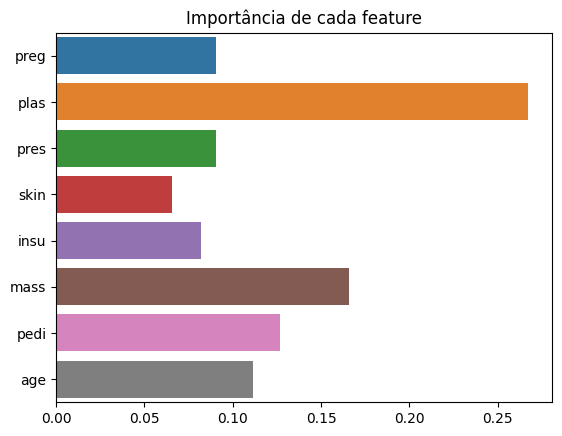

In [ ]:
importances = pd.Series(data=model.feature_importances_, index=model.feature_names_in_)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature')

As 8 primeiro colunas são dados que serão utilizados como entrada da rede neural, sendo a ultima(target) é o rótulo da classe que queremos encontrar baseados nas tabelas de entrada.

1.   preg - Número de vezes que a pessoa engravidou
2.   plas - concentração de plasma glucose
3.   pres - pressão sanguinea (mm Hg)
4.   skin - espessura da dobra da pele do tríceps (mm)
5.   insu - hora insulina sérica (mu U/ml)
6.   mass - indice de massa corporal (peso em Kg/altura^2)
7.   pedi - função pedigree de diabetes
8.   age -  idade em anos
9.   target - Classificação do paciente (diabético: sim ou não)

Temos no tatal 768 linhas e 9 colunas, onde  268 pacientes que testaram positivo e 500 pacientes que testaram negativo.

Não há necessidade de excluir colunas pois os valores muito proximos e não nulos, apesar do atributo plas se destacar dentre os demais

In [ ]:
display(dataset)


preg  plas  pres  skin  insu  mass   pedi  age           target
0       6   148    72    35     0  33.6  0.627   50  tested_positive
1       1    85    66    29     0  26.6  0.351   31  tested_negative
2       8   183    64     0     0  23.3  0.672   32  tested_positive
3       1    89    66    23    94  28.1  0.167   21  tested_negative
4       0   137    40    35   168  43.1  2.288   33  tested_positive
..    ...   ...   ...   ...   ...   ...    ...  ...              ...
763    10   101    76    48   180  32.9  0.171   63  tested_negative
764     2   122    70    27     0  36.8  0.340   27  tested_negative
765     5   121    72    23   112  26.2  0.245   30  tested_negative
766     1   126    60     0     0  30.1  0.349   47  tested_positive
767     1    93    70    31     0  30.4  0.315   23  tested_negative

[768 rows x 9 columns]

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   insu    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   target  768 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 54.1+ KB


In [ ]:
dataset.isnull().sum() #para retornar a soma dos valores nulos encontrados

preg      0
plas      0
pres      0
skin      0
insu      0
mass      0
pedi      0
age       0
target    0
dtype: int64

### 2)	Implemente técnicas de visualização de dados e seleção de variáveis para extrair características importantes sobre a base de dados. Explique a motivação destas técnicas e o que é possível inferir dos resultados obtidos.

#### Rascunho

In [ ]:
#Tipos de colunas
dataset.dtypes

preg        int64
plas        int64
pres        int64
skin        int64
insu        int64
mass      float64
pedi      float64
age         int64
target     object
dtype: object

In [ ]:
dataset.describe()#analise de distribuição, média, min, max

preg        plas        pres        skin        insu        mass  \
count  768.000000  768.000000  768.000000  768.000000  768.000000  768.000000   
mean     3.845052  120.894531   69.105469   20.536458   79.799479   31.992578   
std      3.369578   31.972618   19.355807   15.952218  115.244002    7.884160   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   62.000000    0.000000    0.000000   27.300000   
50%      3.000000  117.000000   72.000000   23.000000   30.500000   32.000000   
75%      6.000000  140.250000   80.000000   32.000000  127.250000   36.600000   
max     17.000000  199.000000  122.000000   99.000000  846.000000   67.100000   

             pedi         age  
count  768.000000  768.000000  
mean     0.471876   33.240885  
std      0.331329   11.760232  
min      0.078000   21.000000  
25%      0.243750   24.000000  
50%      0.372500   29.000000  
75%      0.626250   41.000000  
max      2.420000   81.000000

In [ ]:
dataset.groupby(by='target').mean()

preg        plas       pres       skin        insu  \
target                                                                    
tested_negative  3.298000  109.980000  68.184000  19.664000   68.792000   
tested_positive  4.865672  141.257463  70.824627  22.164179  100.335821   

                      mass      pedi        age  
target                                           
tested_negative  30.304200  0.429734  31.190000  
tested_positive  35.142537  0.550500  37.067164

In [ ]:
dataset.groupby(by='target').count() #Apresenta mais testes negativos do que positivos e pode prejudicar a rede neural

preg  plas  pres  skin  insu  mass  pedi  age
target                                                        
tested_negative   500   500   500   500   500   500   500  500
tested_positive   268   268   268   268   268   268   268  268

In [ ]:
#Dividindo dados
dataset_positive = dataset.loc[dataset['target'] == 'tested_positive'] #268 dados
dataset_negative = dataset.loc[dataset['target'] == 'tested_negative'] #500 dados

#### Resposta

Percebemos que existiam mais dados de teste negativos do que testes positivos e isso prejudicaria o treinamento da rede neural

In [ ]:
dataset.groupby(by='target').count()

preg  plas  pres  skin  insu  mass  pedi  age
target                                                        
tested_negative   500   500   500   500   500   500   500  500
tested_positive   268   268   268   268   268   268   268  268

In [ ]:
#Dividindo dados
dataset_positive = dataset.loc[dataset['target'] == 'tested_positive'] #268 dados
dataset_negative = dataset.loc[dataset['target'] == 'tested_negative'] #500 dados

In [ ]:
#Pegando os dados de forma aleatoria
df_shuffled=sklearn.utils.shuffle(dataset_negative).reset_index(drop=True) # embaralhar a coluna negativa
dataset_negative_new = df_shuffled.loc[0:267,:] # apenas 268 colunas para se igualar ao dataset positivo
new = pd.concat([dataset_positive, dataset_negative_new]).reset_index(drop=True)  #concatenar o dataset positivo e negativo



In [ ]:
dataset = sklearn.utils.shuffle(new).reset_index(drop=True)
print(dataset)

     preg  plas  pres  skin  insu  mass   pedi  age           target
0       3    84    68    30   106  31.9  0.591   25  tested_negative
1       5    88    66    21    23  24.4  0.342   30  tested_negative
2       1    88    30    42    99  55.0  0.496   26  tested_positive
3       1   151    60     0     0  26.1  0.179   22  tested_negative
4       3   111    62     0     0  22.6  0.142   21  tested_negative
..    ...   ...   ...   ...   ...   ...    ...  ...              ...
531     0   180    78    63    14  59.4  2.420   25  tested_positive
532    12   140    82    43   325  39.2  0.528   58  tested_positive
533     2   144    58    33   135  31.6  0.422   25  tested_positive
534     7   194    68    28     0  35.9  0.745   41  tested_positive
535     3    82    70     0     0  21.1  0.389   25  tested_negative

[536 rows x 9 columns]


In [ ]:
dataset.describe()

preg        plas        pres        skin        insu        mass  \
count  536.000000  536.000000  536.000000  536.000000  536.000000  536.000000   
mean     4.044776  125.425373   69.470149   21.097015   81.531716   32.866604   
std      3.504050   33.723588   20.209072   16.512751  121.715091    7.882600   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000  101.000000   64.000000    0.000000    0.000000   28.175000   
50%      3.000000  122.000000   72.000000   24.500000   14.500000   32.800000   
75%      7.000000  147.000000   80.000000   33.000000  130.000000   37.500000   
max     17.000000  199.000000  114.000000   99.000000  846.000000   67.100000   

             pedi         age  
count  536.000000  536.000000  
mean     0.498151   34.141791  
std      0.358443   11.622346  
min      0.085000   21.000000  
25%      0.247750   25.000000  
50%      0.385500   31.000000  
75%      0.655750   42.000000  
max      2.420000   81.000000

In [ ]:
#sns.pairplot(dataset, hue="target", diag_kind="hist")
import seaborn as sns 


Análisando o grafico de calor (heatmap), podemos visualizar as variáveis que mais se correlacionam.

O objetivo do estudo da correlação é determinar (mensurar) o grau de relacionamento entre duas variáveis.

<ipython-input-27-b85ce089f1e1>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataset.corr() , annot = True , ax = ax)


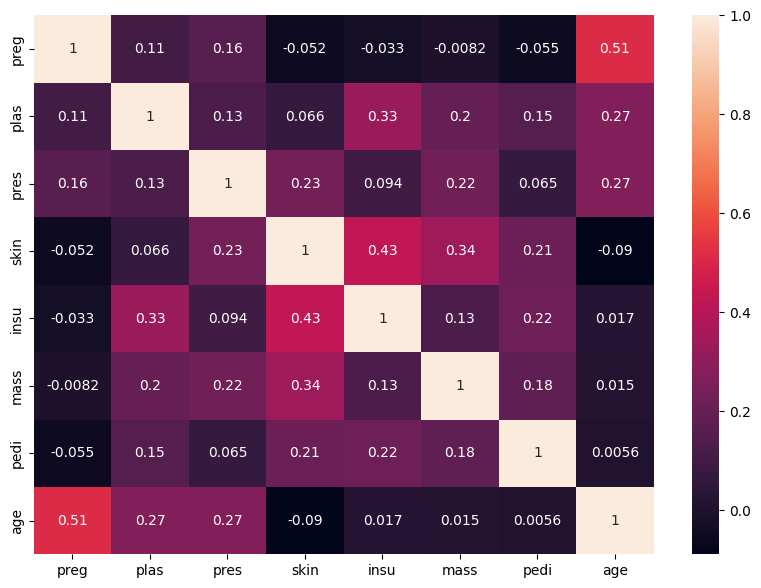

In [ ]:
fig , ax = plt.subplots(figsize = (10,7))
sns.heatmap(dataset.corr() , annot = True , ax = ax)
plt.show()

A análise de clustermap permite visualizar um agrupamento hierarquico dos atributos.

<ipython-input-28-8259e63cf957>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.clustermap(dataset.corr(), figsize=(10, 10), method="ward", cmap="coolwarm_r")


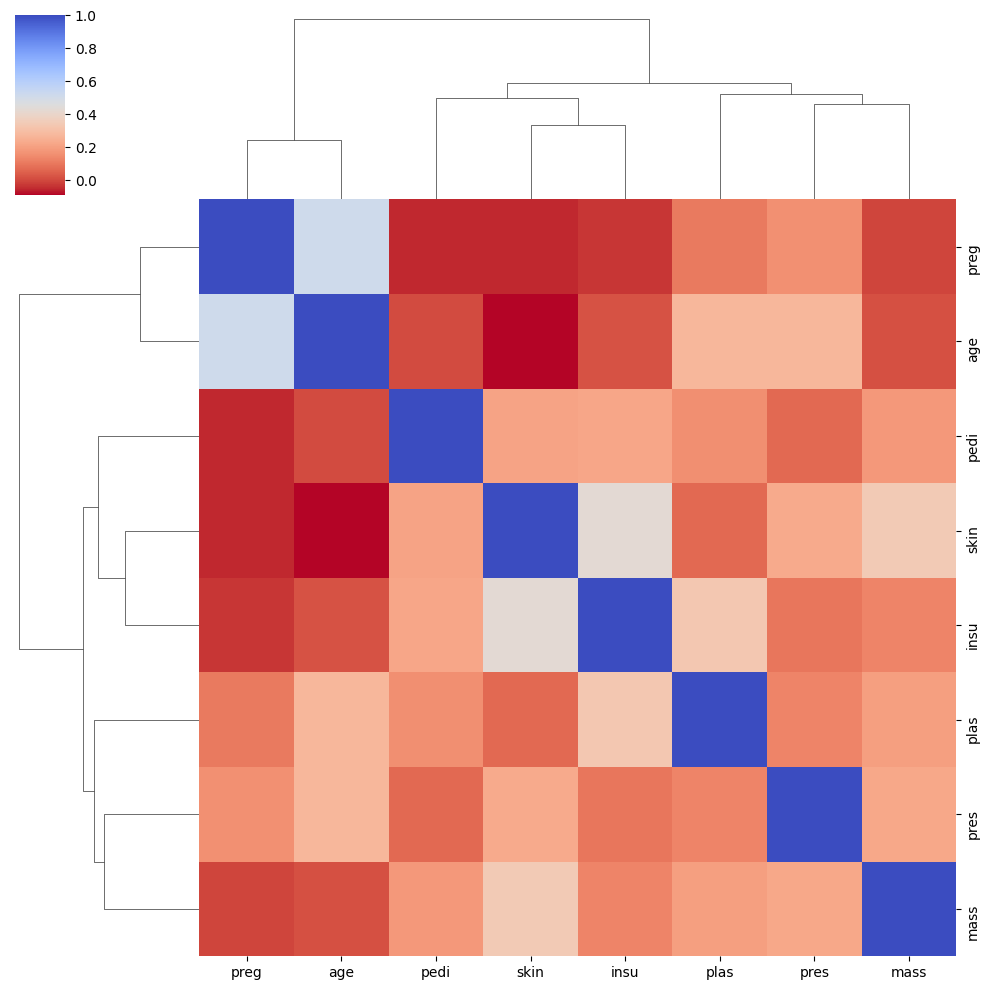

In [ ]:
sns.clustermap(dataset.corr(), figsize=(10, 10), method="ward", cmap="coolwarm_r")

Através da análise de pairplot, vemos que não é possivel separar os conjuntos linearmente a partir dessas variáveis, por essa razão a técnica de redes neurais é uma das mais indicadas.

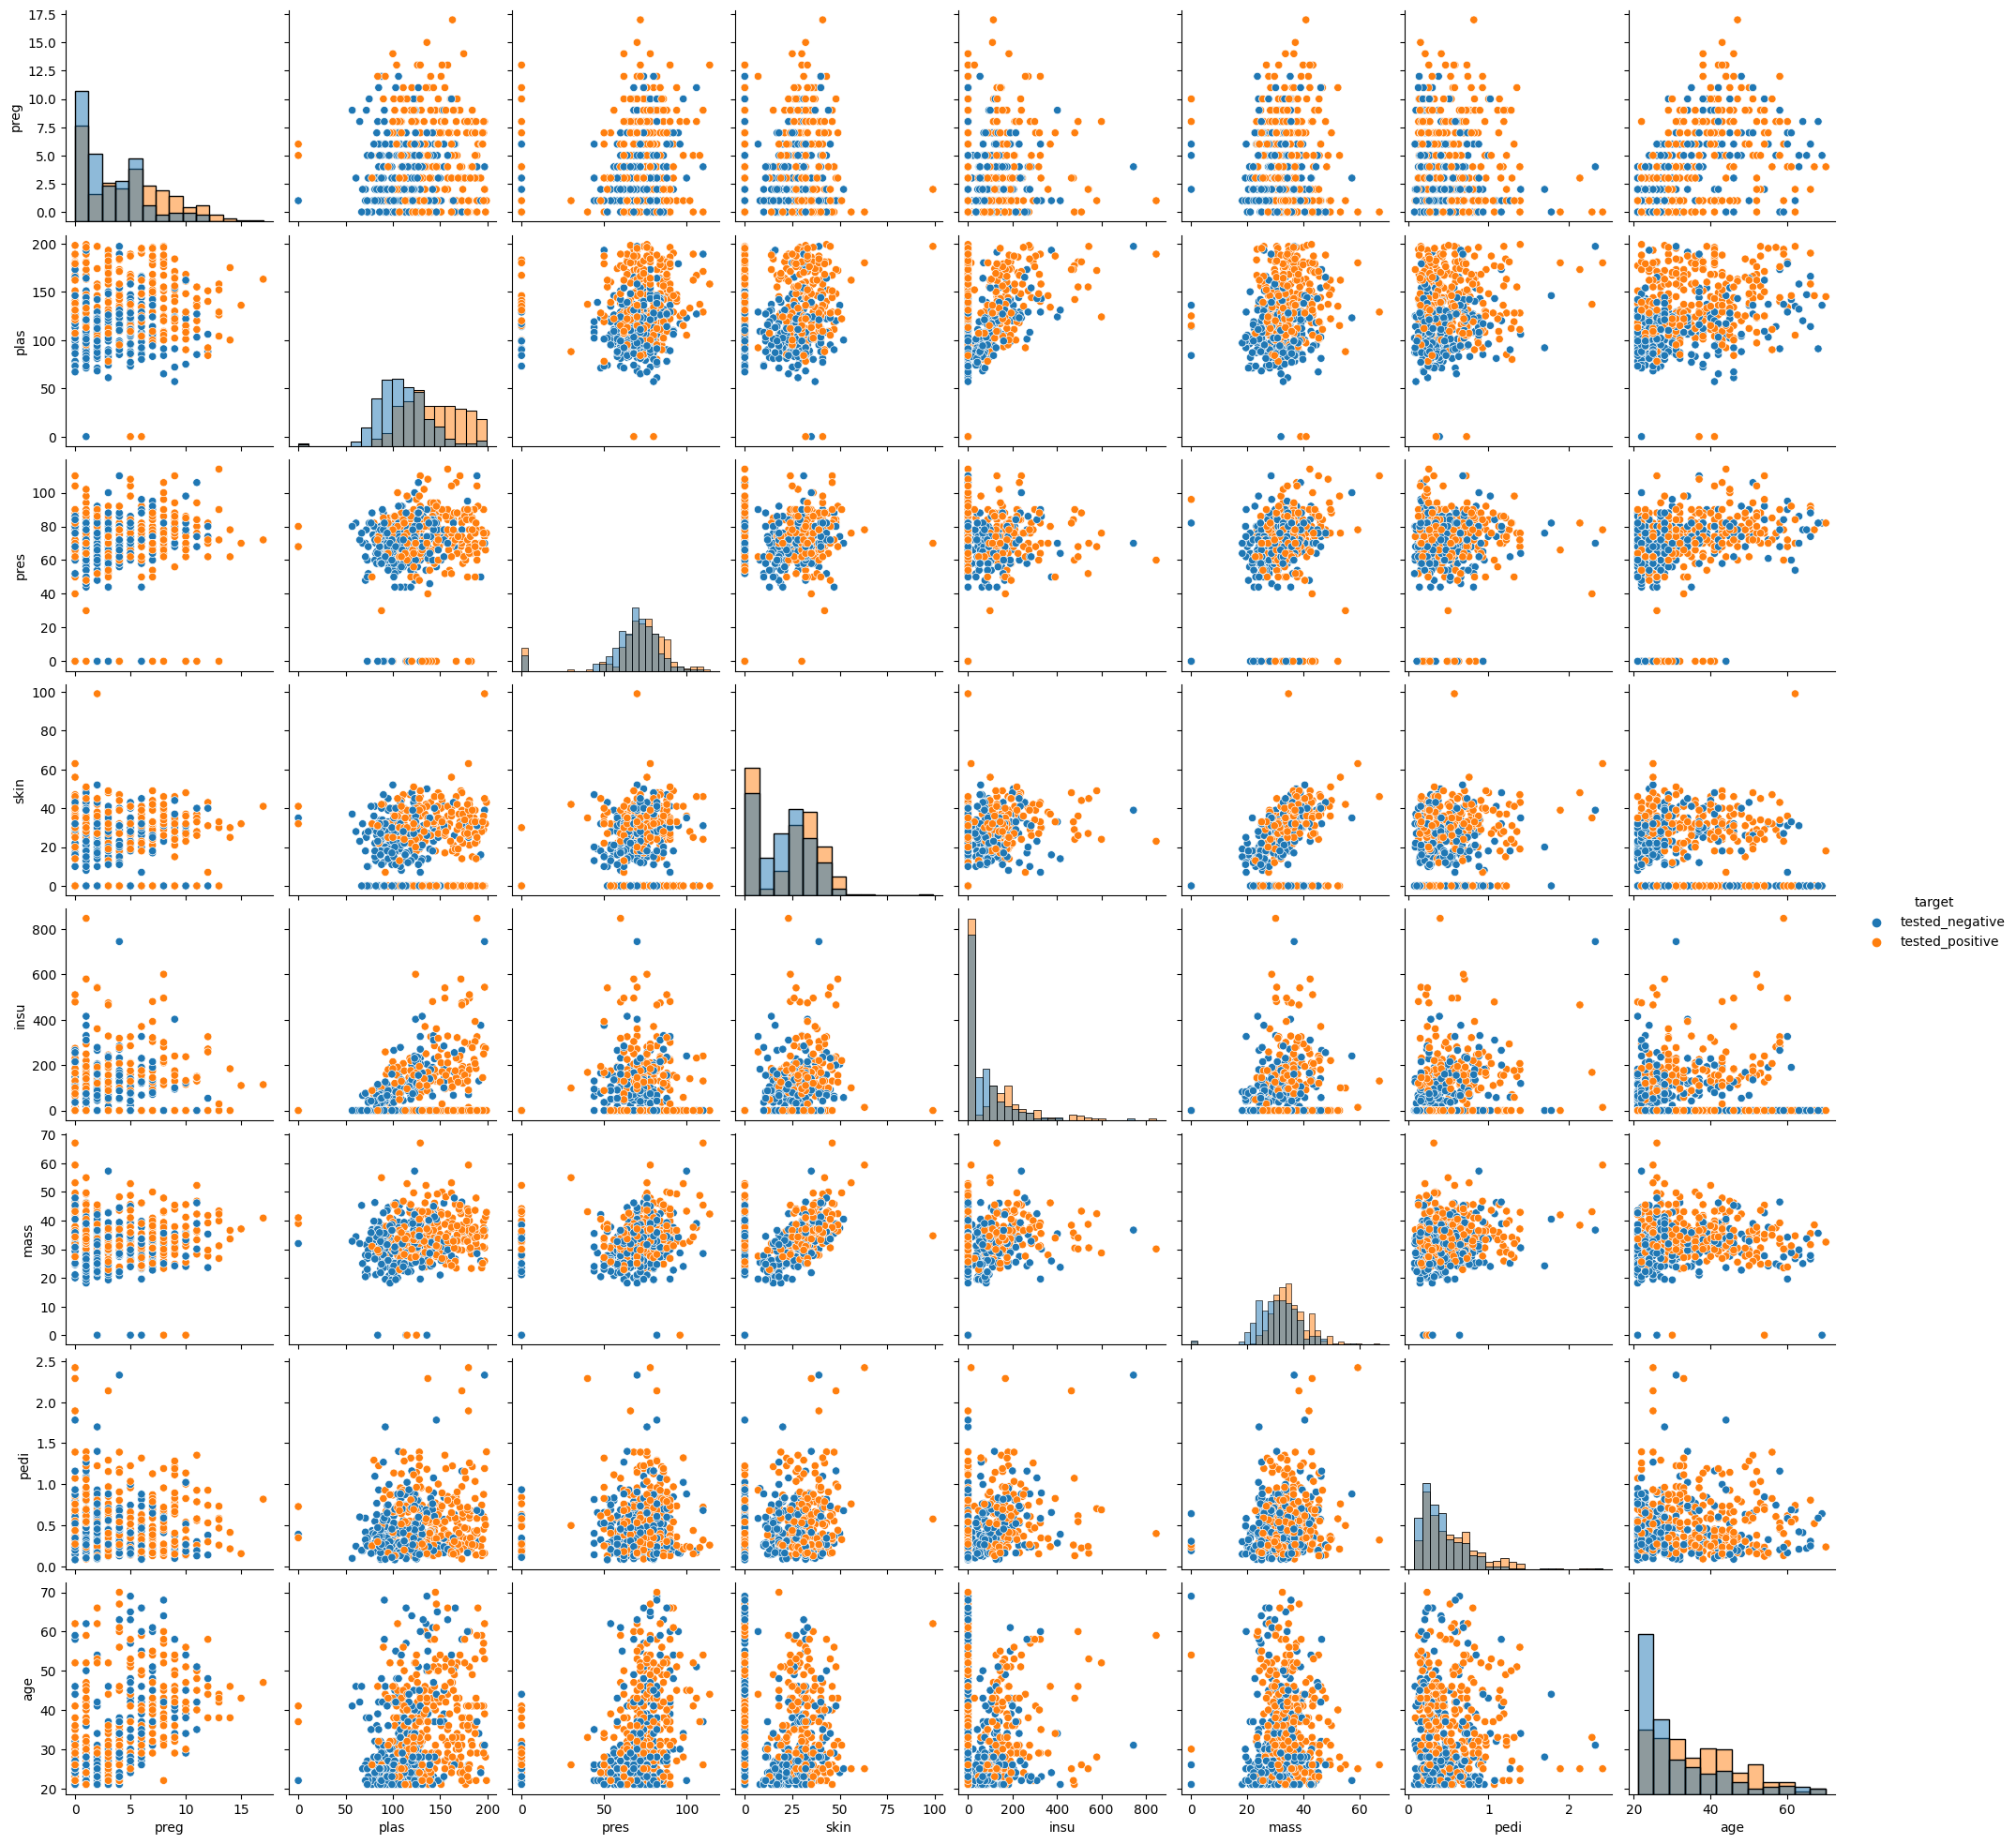

In [ ]:
sns.pairplot(dataset, hue="target", diag_kind="hist")

## Parte II. Treinamento do modelo de Rede Neural - Baseline 

Total: 1,0 pts.

### 1)	Com as configurações do modelo MLP previamente definidas no script, faça o treinamento da Rede Neural sem normalizar os atributos numéricos. Comente o resultado obtido, baseado nas métricas de avaliação disponíveis (acurácia, precision, recall, F1-Score, Matriz de confusão, etc.)

#### Rascunho

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
#Os dados de entrada não foram normalizados como solicitado no enunciado
new_df_not_normalized = transform_data(dataset, normalize=False)


In [ ]:
new_df_not_normalized.head()

preg  plas  pres  skin  insu  mass   pedi  age           target
0     3    84    68    30   106  31.9  0.591   25  tested_negative
1     5    88    66    21    23  24.4  0.342   30  tested_negative
2     1    88    30    42    99  55.0  0.496   26  tested_positive
3     1   151    60     0     0  26.1  0.179   22  tested_negative
4     3   111    62     0     0  22.6  0.142   21  tested_negative

In [ ]:
X = new_df_not_normalized.values[:,:-1].astype('float') #tranasforma as variáveis de entrada em float, exceto a ultima (target)
target = new_df_not_normalized.values[:,-1] #Vetor de saida (output), para comparação

encoder = LabelEncoder() #codificador de dados
y = encoder.fit_transform(target) # binariza a saida

n_input = X.shape[1] #numero de neuronios de entradas

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1 #número de neurônios na camada de saida
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]

Binary classification


In [ ]:
batch_size = 32  #definindo batchs
epochs = 250  #definindo épocas

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42) #Divide o conjunto de entrada em test e treino
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42) #divide o conjunto de treino em treino e validação

In [ ]:
#Para o caso binário
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))


train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
train_dataset.X_data

tensor([[ 10.0000, 125.0000,  70.0000,  ...,  31.1000,   0.2050,  41.0000],
        [  1.0000, 172.0000,  68.0000,  ...,  42.4000,   0.7020,  28.0000],
        [  7.0000,  97.0000,  76.0000,  ...,  40.9000,   0.8710,  32.0000],
        ...,
        [  5.0000, 143.0000,  78.0000,  ...,  45.0000,   0.1900,  47.0000],
        [  1.0000,  95.0000,  82.0000,  ...,  35.0000,   0.2330,  43.0000],
        [  0.0000, 113.0000,  80.0000,  ...,  31.0000,   0.8740,  21.0000]])

In [ ]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')

In [ ]:
lr = 0.01
ep = 250

history, y_hat = train(model, train_loader, val_dataset, epochs=ep, lr=lr, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.207 | Val Loss: 0.7547 | Train Acc: 50.6364| Val Acc: 43.0000
Epoch 002: | Train Loss: 0.725 | Val Loss: 0.7426 | Train Acc: 49.8182| Val Acc: 41.0000
Epoch 003: | Train Loss: 0.717 | Val Loss: 0.7395 | Train Acc: 50.6364| Val Acc: 41.0000
Epoch 004: | Train Loss: 0.714 | Val Loss: 0.7366 | Train Acc: 50.6364| Val Acc: 40.0000
Epoch 005: | Train Loss: 0.713 | Val Loss: 0.7341 | Train Acc: 50.6364| Val Acc: 38.0000
Epoch 006: | Train Loss: 0.712 | Val Loss: 0.7319 | Train Acc: 50.6364| Val Acc: 38.0000
Epoch 007: | Train Loss: 0.711 | Val Loss: 0.7299 | Train Acc: 50.6364| Val Acc: 41.0000
Epoch 008: | Train Loss: 0.709 | Val Loss: 0.7295 | Train Acc: 50.3636| Val Acc: 42.0000
Epoch 009: | Train Loss: 0.709 | Val Loss: 0.7273 | Train Acc: 50.3636| Val Acc: 43.0000
Epoch 010: | Train Loss: 0.708 | Val Loss: 0.7254 | Train Acc: 50.3636| Val Acc: 45.0000
Epoch 011: | Train Loss: 0.707 | Val Loss: 0.7251 | Train Acc: 50.6364| Val Acc: 45.0000
Epoch 012: | Train Lo

In [ ]:
y_pred = model.predict(test_dataset.X_data, binary=binary)

#### Resposta

Modelo não aprendeu, o erro está estaguinado
paralisia da rede, não aprendeu  pois não esta normalizado




In [ ]:
#Os dados de entrada não foram normalizados como solicitado no enunciado
new_df_not_normalized = transform_data(dataset, normalize=False)

In [ ]:
new_df_not_normalized.head()

preg  plas  pres  skin  insu  mass   pedi  age           target
0     3    84    68    30   106  31.9  0.591   25  tested_negative
1     5    88    66    21    23  24.4  0.342   30  tested_negative
2     1    88    30    42    99  55.0  0.496   26  tested_positive
3     1   151    60     0     0  26.1  0.179   22  tested_negative
4     3   111    62     0     0  22.6  0.142   21  tested_negative

In [ ]:
print(accuracy_score(y_test, y_pred))

0.5370370370370371


In [ ]:
print(recall_score(y_test, y_pred, average='macro'))

0.5233516483516484


In [ ]:
print(precision_score(y_test, y_pred, average='macro'))

0.5516717325227963


In [ ]:
print(f1_score(y_test, y_pred, average='macro'))

0.4545454545454546


              precision    recall  f1-score   support

           0       0.53      0.89      0.67        56
           1       0.57      0.15      0.24        52

    accuracy                           0.54       108
   macro avg       0.55      0.52      0.45       108
weighted avg       0.55      0.54      0.46       108



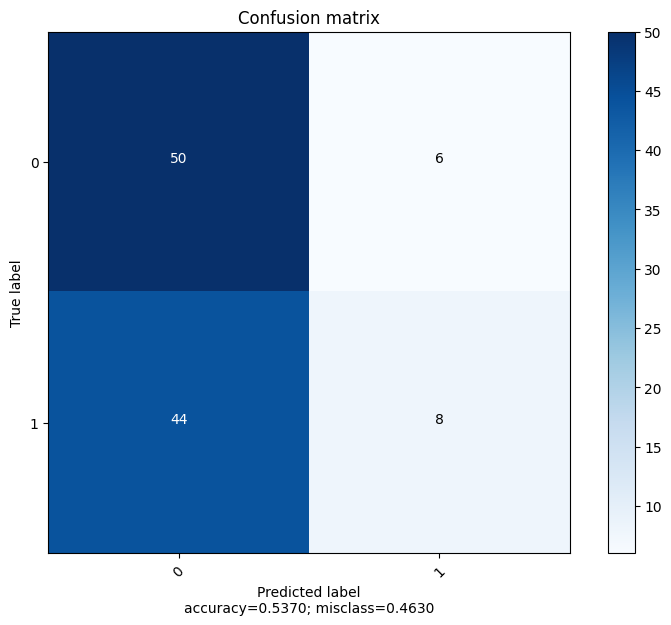

In [ ]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

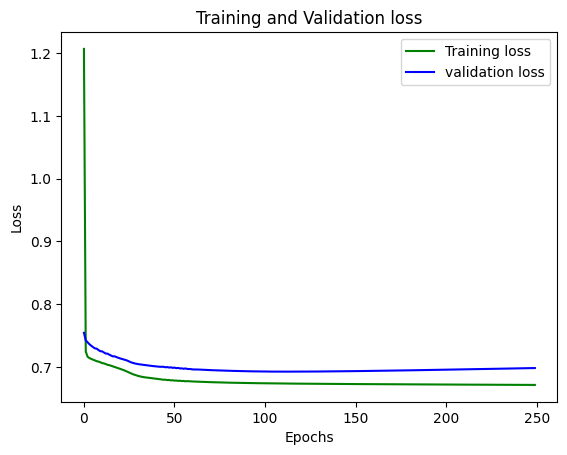

In [ ]:
loss_train = history['loss_train']
loss_val = history['loss_val']
ep = range(0,250)
plt.plot(ep, loss_train, 'g', label='Training loss')
plt.plot(ep, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

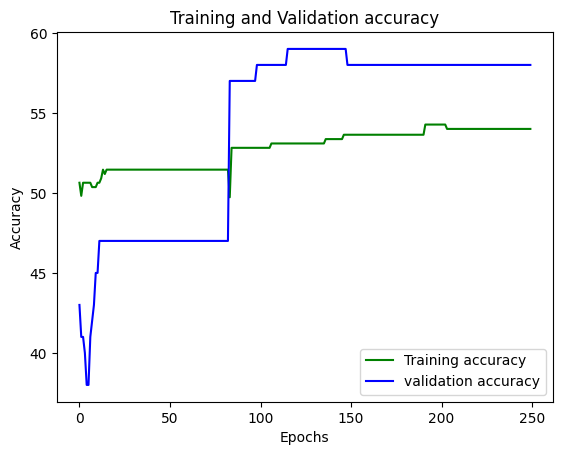

In [ ]:
acc_train = history['acc_train']
acc_val = history['acc_val']
epochs = range(0,250)
plt.plot(ep, acc_train, 'g', label='Training accuracy')
plt.plot(ep, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Parte III - Mudança de configurações do modelo

Total: 5,0 pts.

### 1)	Agora normalize os dados de entrada e treine novamente o modelo MLP. Avalie os resultados obtidos e comente o efeito da normalização no treinamento da Rede Neural.

#### Rascunho
alterar epocas e apendizado para ter um resultdo melhor

In [ ]:
new_df_normalized = transform_data(dataset, normalize=True)
new_df_normalized.head()

preg      plas      pres      skin      insu      mass      pedi  \
0  0.176471  0.422111  0.596491  0.303030  0.125296  0.475410  0.216702   
1  0.294118  0.442211  0.578947  0.212121  0.027187  0.363636  0.110064   
2  0.058824  0.442211  0.263158  0.424242  0.117021  0.819672  0.176017   
3  0.058824  0.758794  0.526316  0.000000  0.000000  0.388972  0.040257   
4  0.176471  0.557789  0.543860  0.000000  0.000000  0.336811  0.024411   

        age           target  
0  0.066667  tested_negative  
1  0.150000  tested_negative  
2  0.083333  tested_positive  
3  0.016667  tested_negative  
4  0.000000  tested_negative

In [ ]:
X = new_df_normalized.values[:,:-1].astype('float')
target = new_df_normalized.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1] #numero de neuronios de entradas
n_output = 1 #número de neurônios na camada de saida
binary = True


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [ ]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=32)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=250, lr=0.01, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.706 | Val Loss: 0.7100 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 002: | Train Loss: 0.705 | Val Loss: 0.7091 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 003: | Train Loss: 0.704 | Val Loss: 0.7082 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 004: | Train Loss: 0.704 | Val Loss: 0.7074 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 005: | Train Loss: 0.703 | Val Loss: 0.7067 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 006: | Train Loss: 0.702 | Val Loss: 0.7059 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 007: | Train Loss: 0.702 | Val Loss: 0.7053 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 008: | Train Loss: 0.701 | Val Loss: 0.7047 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 009: | Train Loss: 0.701 | Val Loss: 0.7041 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 010: | Train Loss: 0.700 | Val Loss: 0.7035 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 011: | Train Loss: 0.700 | Val Loss: 0.7030 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 012: | Train Lo

#### Resposta

Com os dados normalizados o resultado foi bem melhor, apesar da acurácia ainda ser baixa e precisar mudar outros parâmetros.

In [ ]:
new_df_normalized = transform_data(dataset, normalize=True)
new_df_normalized.head()

preg      plas      pres      skin      insu      mass      pedi  \
0  0.176471  0.422111  0.596491  0.303030  0.125296  0.475410  0.216702   
1  0.294118  0.442211  0.578947  0.212121  0.027187  0.363636  0.110064   
2  0.058824  0.442211  0.263158  0.424242  0.117021  0.819672  0.176017   
3  0.058824  0.758794  0.526316  0.000000  0.000000  0.388972  0.040257   
4  0.176471  0.557789  0.543860  0.000000  0.000000  0.336811  0.024411   

        age           target  
0  0.066667  tested_negative  
1  0.150000  tested_negative  
2  0.083333  tested_positive  
3  0.016667  tested_negative  
4  0.000000  tested_negative

In [ ]:
y_pred = model.predict(test_dataset.X_data,binary=binary)


              precision    recall  f1-score   support

           0       0.73      0.43      0.54        56
           1       0.57      0.83      0.68        52

    accuracy                           0.62       108
   macro avg       0.65      0.63      0.61       108
weighted avg       0.65      0.62      0.61       108



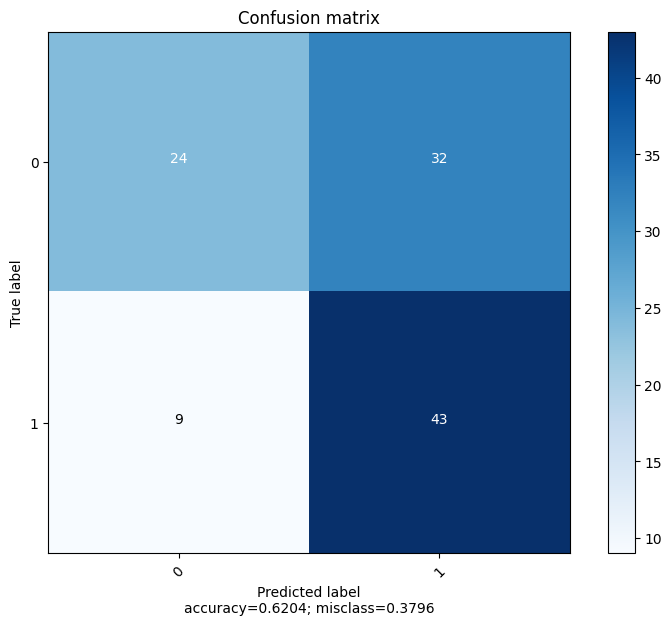

In [ ]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

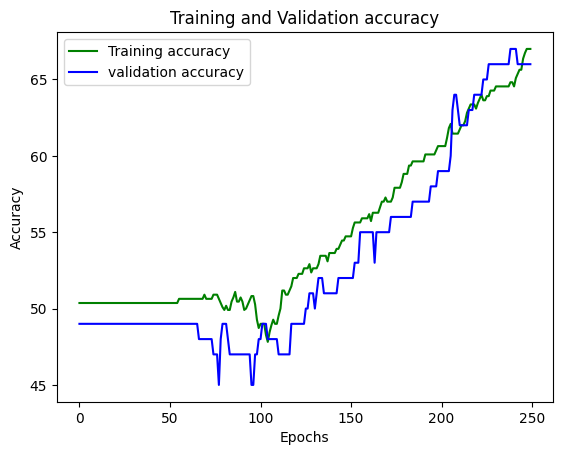

In [ ]:
acc_train = history['acc_train']
acc_val = history['acc_val']
ep = range(0,250)
plt.plot(ep, acc_train, 'g', label='Training accuracy')
plt.plot(ep, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 2)	Modifique o tempo de treinamento (épocas) da Rede Neural. Escolha valores distintos (e.g. 1 e 1000 épocas) e avalie os resultados.

#### Rascunho

In [ ]:
new_df_normalized.head()

preg      plas      pres      skin      insu      mass      pedi  \
0  0.176471  0.422111  0.596491  0.303030  0.125296  0.475410  0.216702   
1  0.294118  0.442211  0.578947  0.212121  0.027187  0.363636  0.110064   
2  0.058824  0.442211  0.263158  0.424242  0.117021  0.819672  0.176017   
3  0.058824  0.758794  0.526316  0.000000  0.000000  0.388972  0.040257   
4  0.176471  0.557789  0.543860  0.000000  0.000000  0.336811  0.024411   

        age           target  
0  0.066667  tested_negative  
1  0.150000  tested_negative  
2  0.083333  tested_positive  
3  0.016667  tested_negative  
4  0.000000  tested_negative

In [ ]:
lr=0.01


In [ ]:
X = new_df_normalized.values[:,:-1].astype('float')
target = new_df_normalized.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1] #numero de neuronios de entradas
n_output = 1 #número de neurônios na camada de saida
batch_size = 32
binary = True

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [ ]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')

In [ ]:
epochs = [1,10,20,25,30,50,75,90,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000]

accuracy = []
precision = []
f1score = []
recall = []

for x in range(0,len(epochs)):
  history, y_hat = train(model, train_loader, val_dataset, epochs=epochs[x], lr=lr, device=device, binary=binary)
  y_pred = model.predict(test_dataset.X_data,binary=binary)

  accuracy.append(accuracy_score(y_test, y_pred))
  precision.append(precision_score(y_test, y_pred,average='weighted'))
  f1score.append(f1_score(y_test, y_pred,average='weighted'))
  recall.append(recall_score(y_test, y_pred,average='weighted'))


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.699 | Val Loss: 0.6945 | Train Acc: 48.7273| Val Acc: 51.0000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.699 | Val Loss: 0.6944 | Train Acc: 49.0000| Val Acc: 51.0000
Epoch 002: | Train Loss: 0.698 | Val Loss: 0.6943 | Train Acc: 48.7273| Val Acc: 51.0000
Epoch 003: | Train Loss: 0.698 | Val Loss: 0.6941 | Train Acc: 48.7273| Val Acc: 51.0000
Epoch 004: | Train Loss: 0.698 | Val Loss: 0.6940 | Train Acc: 48.4545| Val Acc: 52.0000
Epoch 005: | Train Loss: 0.698 | Val Loss: 0.6940 | Train Acc: 48.4545| Val Acc: 52.0000
Epoch 006: | Train Loss: 0.698 | Val Loss: 0.6939 | Train Acc: 48.4545| Val Acc: 52.0000
Epoch 007: | Train Loss: 0.697 | Val Loss: 0.6938 | Train Acc: 48.4545| Val Acc: 52.0000
Epoch 008: | Train Loss: 0.697 | Val Loss: 0.6937 | Train Acc: 48.7273| Val Acc: 51.0000
Epoch 009: | Train Loss: 0.697 | Val Loss: 0.6936 | Train Acc: 48.4545| Val Acc: 51.0000
Epoch 010: | Train Loss: 0.697 | Val Loss: 0.6935 | Train Acc: 48.0000| Val Acc: 51.0000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.697 | Val Loss: 0.6934 | Train Acc: 47.4545| Val Acc: 51.0000
Epoch 002: | Train Loss: 0.696 | Val Loss: 0.6933 | Train Acc: 48.0000| Val Acc: 52.0000
Epoch 003: | Train Loss: 0.696 | Val Loss: 0.6933 | Train Acc: 46.9091| Val Acc: 51.0000
Epoch 004: | Train Loss: 0.696 | Val Loss: 0.6932 | Train Acc: 46.6364| Val Acc: 51.0000
Epoch 005: | Train Loss: 0.696 | Val Loss: 0.6931 | Train Acc: 46.3636| Val Acc: 50.0000
Epoch 006: | Train Loss: 0.696 | Val Loss: 0.6930 | Train Acc: 47.1818| Val Acc: 53.0000
Epoch 007: | Train Loss: 0.696 | Val Loss: 0.6930 | Train Acc: 47.3636| Val Acc: 56.0000
Epoch 008: | Train Loss: 0.695 | Val Loss: 0.6929 | Train Acc: 48.1818| Val Acc: 56.0000
Epoch 009: | Train Loss: 0.695 | Val Loss: 0.6928 | Train Acc: 48.7273| Val Acc: 55.0000
Epoch 010: | Train Loss: 0.695 | Val Loss: 0.6927 | Train Acc: 49.5455| Val Acc: 55.0000
Epoch 011: | Train Loss: 0.695 | Val Loss: 0.6926 | Train Acc: 49.2727| Val Acc: 56.0000
Epoch 012: | Train Lo

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.693 | Val Loss: 0.6921 | Train Acc: 51.4545| Val Acc: 57.0000
Epoch 002: | Train Loss: 0.693 | Val Loss: 0.6921 | Train Acc: 52.1818| Val Acc: 57.0000
Epoch 003: | Train Loss: 0.693 | Val Loss: 0.6920 | Train Acc: 51.9091| Val Acc: 55.0000
Epoch 004: | Train Loss: 0.693 | Val Loss: 0.6920 | Train Acc: 53.0909| Val Acc: 56.0000
Epoch 005: | Train Loss: 0.693 | Val Loss: 0.6920 | Train Acc: 53.4545| Val Acc: 57.0000
Epoch 006: | Train Loss: 0.693 | Val Loss: 0.6919 | Train Acc: 54.5455| Val Acc: 57.0000
Epoch 007: | Train Loss: 0.693 | Val Loss: 0.6919 | Train Acc: 55.3636| Val Acc: 56.0000
Epoch 008: | Train Loss: 0.693 | Val Loss: 0.6918 | Train Acc: 55.3636| Val Acc: 55.0000
Epoch 009: | Train Loss: 0.693 | Val Loss: 0.6918 | Train Acc: 54.6364| Val Acc: 56.0000
Epoch 010: | Train Loss: 0.693 | Val Loss: 0.6918 | Train Acc: 54.6364| Val Acc: 56.0000
Epoch 011: | Train Loss: 0.692 | Val Loss: 0.6917 | Train Acc: 55.3636| Val Acc: 56.0000
Epoch 012: | Train Lo

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.691 | Val Loss: 0.6913 | Train Acc: 54.8182| Val Acc: 57.0000
Epoch 002: | Train Loss: 0.691 | Val Loss: 0.6913 | Train Acc: 54.8182| Val Acc: 57.0000
Epoch 003: | Train Loss: 0.691 | Val Loss: 0.6913 | Train Acc: 54.8182| Val Acc: 57.0000
Epoch 004: | Train Loss: 0.691 | Val Loss: 0.6913 | Train Acc: 55.0909| Val Acc: 57.0000
Epoch 005: | Train Loss: 0.691 | Val Loss: 0.6912 | Train Acc: 55.3636| Val Acc: 57.0000
Epoch 006: | Train Loss: 0.691 | Val Loss: 0.6912 | Train Acc: 54.9091| Val Acc: 58.0000
Epoch 007: | Train Loss: 0.691 | Val Loss: 0.6912 | Train Acc: 55.4545| Val Acc: 58.0000
Epoch 008: | Train Loss: 0.691 | Val Loss: 0.6912 | Train Acc: 56.2727| Val Acc: 59.0000
Epoch 009: | Train Loss: 0.691 | Val Loss: 0.6912 | Train Acc: 56.5455| Val Acc: 59.0000
Epoch 010: | Train Loss: 0.691 | Val Loss: 0.6911 | Train Acc: 57.0909| Val Acc: 59.0000
Epoch 011: | Train Loss: 0.691 | Val Loss: 0.6911 | Train Acc: 57.0909| Val Acc: 59.0000
Epoch 012: | Train Lo

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.689 | Val Loss: 0.6906 | Train Acc: 60.7273| Val Acc: 60.0000
Epoch 002: | Train Loss: 0.689 | Val Loss: 0.6905 | Train Acc: 61.0000| Val Acc: 60.0000
Epoch 003: | Train Loss: 0.689 | Val Loss: 0.6905 | Train Acc: 61.2727| Val Acc: 60.0000
Epoch 004: | Train Loss: 0.689 | Val Loss: 0.6905 | Train Acc: 61.2727| Val Acc: 60.0000
Epoch 005: | Train Loss: 0.689 | Val Loss: 0.6904 | Train Acc: 61.0000| Val Acc: 60.0000
Epoch 006: | Train Loss: 0.689 | Val Loss: 0.6904 | Train Acc: 61.0000| Val Acc: 60.0000
Epoch 007: | Train Loss: 0.689 | Val Loss: 0.6904 | Train Acc: 61.0000| Val Acc: 59.0000
Epoch 008: | Train Loss: 0.689 | Val Loss: 0.6903 | Train Acc: 61.5455| Val Acc: 59.0000
Epoch 009: | Train Loss: 0.689 | Val Loss: 0.6903 | Train Acc: 61.5455| Val Acc: 59.0000
Epoch 010: | Train Loss: 0.689 | Val Loss: 0.6903 | Train Acc: 61.8182| Val Acc: 59.0000
Epoch 011: | Train Loss: 0.689 | Val Loss: 0.6902 | Train Acc: 61.5455| Val Acc: 59.0000
Epoch 012: | Train Lo

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.685 | Val Loss: 0.6887 | Train Acc: 66.8182| Val Acc: 63.0000
Epoch 002: | Train Loss: 0.685 | Val Loss: 0.6886 | Train Acc: 66.8182| Val Acc: 63.0000
Epoch 003: | Train Loss: 0.685 | Val Loss: 0.6886 | Train Acc: 67.0909| Val Acc: 63.0000
Epoch 004: | Train Loss: 0.685 | Val Loss: 0.6886 | Train Acc: 67.0909| Val Acc: 63.0000
Epoch 005: | Train Loss: 0.685 | Val Loss: 0.6885 | Train Acc: 67.0909| Val Acc: 63.0000
Epoch 006: | Train Loss: 0.685 | Val Loss: 0.6885 | Train Acc: 67.3636| Val Acc: 63.0000
Epoch 007: | Train Loss: 0.685 | Val Loss: 0.6884 | Train Acc: 68.0909| Val Acc: 63.0000
Epoch 008: | Train Loss: 0.685 | Val Loss: 0.6884 | Train Acc: 68.0909| Val Acc: 63.0000
Epoch 009: | Train Loss: 0.685 | Val Loss: 0.6883 | Train Acc: 68.0909| Val Acc: 63.0000
Epoch 010: | Train Loss: 0.685 | Val Loss: 0.6883 | Train Acc: 68.0909| Val Acc: 63.0000
Epoch 011: | Train Loss: 0.684 | Val Loss: 0.6882 | Train Acc: 68.0909| Val Acc: 63.0000
Epoch 012: | Train Lo

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.676 | Val Loss: 0.6839 | Train Acc: 72.7273| Val Acc: 72.0000
Epoch 002: | Train Loss: 0.676 | Val Loss: 0.6838 | Train Acc: 73.0000| Val Acc: 72.0000
Epoch 003: | Train Loss: 0.675 | Val Loss: 0.6837 | Train Acc: 73.0000| Val Acc: 71.0000
Epoch 004: | Train Loss: 0.675 | Val Loss: 0.6836 | Train Acc: 73.0000| Val Acc: 71.0000
Epoch 005: | Train Loss: 0.675 | Val Loss: 0.6835 | Train Acc: 73.0000| Val Acc: 72.0000
Epoch 006: | Train Loss: 0.675 | Val Loss: 0.6834 | Train Acc: 73.2727| Val Acc: 74.0000
Epoch 007: | Train Loss: 0.675 | Val Loss: 0.6833 | Train Acc: 73.2727| Val Acc: 74.0000
Epoch 008: | Train Loss: 0.674 | Val Loss: 0.6832 | Train Acc: 73.8182| Val Acc: 74.0000
Epoch 009: | Train Loss: 0.674 | Val Loss: 0.6832 | Train Acc: 73.8182| Val Acc: 74.0000
Epoch 010: | Train Loss: 0.674 | Val Loss: 0.6831 | Train Acc: 73.5455| Val Acc: 74.0000
Epoch 011: | Train Loss: 0.674 | Val Loss: 0.6830 | Train Acc: 73.5455| Val Acc: 73.0000
Epoch 012: | Train Lo

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.654 | Val Loss: 0.6736 | Train Acc: 74.0909| Val Acc: 72.0000
Epoch 002: | Train Loss: 0.653 | Val Loss: 0.6735 | Train Acc: 74.0909| Val Acc: 72.0000
Epoch 003: | Train Loss: 0.653 | Val Loss: 0.6733 | Train Acc: 74.0909| Val Acc: 72.0000
Epoch 004: | Train Loss: 0.653 | Val Loss: 0.6732 | Train Acc: 74.0909| Val Acc: 72.0000
Epoch 005: | Train Loss: 0.652 | Val Loss: 0.6730 | Train Acc: 74.0909| Val Acc: 72.0000
Epoch 006: | Train Loss: 0.652 | Val Loss: 0.6729 | Train Acc: 73.8182| Val Acc: 72.0000
Epoch 007: | Train Loss: 0.652 | Val Loss: 0.6728 | Train Acc: 73.5455| Val Acc: 72.0000
Epoch 008: | Train Loss: 0.651 | Val Loss: 0.6726 | Train Acc: 73.5455| Val Acc: 72.0000
Epoch 009: | Train Loss: 0.651 | Val Loss: 0.6725 | Train Acc: 73.5455| Val Acc: 72.0000
Epoch 010: | Train Loss: 0.651 | Val Loss: 0.6723 | Train Acc: 73.2727| Val Acc: 72.0000
Epoch 011: | Train Loss: 0.650 | Val Loss: 0.6722 | Train Acc: 73.8182| Val Acc: 71.0000
Epoch 012: | Train Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.615 | Val Loss: 0.6584 | Train Acc: 74.0909| Val Acc: 69.0000
Epoch 002: | Train Loss: 0.615 | Val Loss: 0.6582 | Train Acc: 74.0909| Val Acc: 69.0000
Epoch 003: | Train Loss: 0.614 | Val Loss: 0.6581 | Train Acc: 74.0909| Val Acc: 69.0000
Epoch 004: | Train Loss: 0.614 | Val Loss: 0.6579 | Train Acc: 74.0909| Val Acc: 69.0000
Epoch 005: | Train Loss: 0.613 | Val Loss: 0.6578 | Train Acc: 74.0909| Val Acc: 69.0000
Epoch 006: | Train Loss: 0.613 | Val Loss: 0.6576 | Train Acc: 74.0909| Val Acc: 69.0000
Epoch 007: | Train Loss: 0.612 | Val Loss: 0.6575 | Train Acc: 74.0909| Val Acc: 69.0000
Epoch 008: | Train Loss: 0.612 | Val Loss: 0.6573 | Train Acc: 74.0909| Val Acc: 69.0000
Epoch 009: | Train Loss: 0.612 | Val Loss: 0.6572 | Train Acc: 74.0909| Val Acc: 69.0000
Epoch 010: | Train Loss: 0.611 | Val Loss: 0.6570 | Train Acc: 74.0909| Val Acc: 67.0000
Epoch 011: | Train Loss: 0.611 | Val Loss: 0.6569 | Train Acc: 74.0909| Val Acc: 67.0000
Epoch 012: | Train Lo

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.562 | Val Loss: 0.6411 | Train Acc: 75.0000| Val Acc: 65.0000
Epoch 002: | Train Loss: 0.561 | Val Loss: 0.6410 | Train Acc: 75.0000| Val Acc: 65.0000
Epoch 003: | Train Loss: 0.561 | Val Loss: 0.6408 | Train Acc: 75.0000| Val Acc: 65.0000
Epoch 004: | Train Loss: 0.561 | Val Loss: 0.6406 | Train Acc: 75.0000| Val Acc: 65.0000
Epoch 005: | Train Loss: 0.560 | Val Loss: 0.6404 | Train Acc: 75.0000| Val Acc: 65.0000
Epoch 006: | Train Loss: 0.560 | Val Loss: 0.6403 | Train Acc: 75.0000| Val Acc: 65.0000
Epoch 007: | Train Loss: 0.560 | Val Loss: 0.6401 | Train Acc: 75.0000| Val Acc: 65.0000
Epoch 008: | Train Loss: 0.560 | Val Loss: 0.6399 | Train Acc: 75.0000| Val Acc: 65.0000
Epoch 009: | Train Loss: 0.559 | Val Loss: 0.6398 | Train Acc: 75.2727| Val Acc: 65.0000
Epoch 010: | Train Loss: 0.559 | Val Loss: 0.6396 | Train Acc: 75.2727| Val Acc: 65.0000
Epoch 011: | Train Loss: 0.559 | Val Loss: 0.6395 | Train Acc: 75.5455| Val Acc: 65.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.529 | Val Loss: 0.6219 | Train Acc: 75.6364| Val Acc: 65.0000
Epoch 002: | Train Loss: 0.529 | Val Loss: 0.6218 | Train Acc: 75.6364| Val Acc: 65.0000
Epoch 003: | Train Loss: 0.529 | Val Loss: 0.6218 | Train Acc: 75.6364| Val Acc: 65.0000
Epoch 004: | Train Loss: 0.528 | Val Loss: 0.6217 | Train Acc: 75.6364| Val Acc: 65.0000
Epoch 005: | Train Loss: 0.528 | Val Loss: 0.6216 | Train Acc: 75.6364| Val Acc: 65.0000
Epoch 006: | Train Loss: 0.528 | Val Loss: 0.6215 | Train Acc: 75.6364| Val Acc: 65.0000
Epoch 007: | Train Loss: 0.528 | Val Loss: 0.6215 | Train Acc: 75.6364| Val Acc: 65.0000
Epoch 008: | Train Loss: 0.528 | Val Loss: 0.6214 | Train Acc: 75.6364| Val Acc: 65.0000
Epoch 009: | Train Loss: 0.528 | Val Loss: 0.6213 | Train Acc: 75.6364| Val Acc: 65.0000
Epoch 010: | Train Loss: 0.528 | Val Loss: 0.6212 | Train Acc: 75.6364| Val Acc: 65.0000
Epoch 011: | Train Loss: 0.528 | Val Loss: 0.6212 | Train Acc: 75.6364| Val Acc: 65.0000
Epoch 012: | Train Lo

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.510 | Val Loss: 0.6094 | Train Acc: 75.9091| Val Acc: 65.0000
Epoch 002: | Train Loss: 0.510 | Val Loss: 0.6094 | Train Acc: 75.9091| Val Acc: 65.0000
Epoch 003: | Train Loss: 0.510 | Val Loss: 0.6094 | Train Acc: 75.9091| Val Acc: 65.0000
Epoch 004: | Train Loss: 0.510 | Val Loss: 0.6094 | Train Acc: 75.9091| Val Acc: 65.0000
Epoch 005: | Train Loss: 0.510 | Val Loss: 0.6094 | Train Acc: 75.9091| Val Acc: 65.0000
Epoch 006: | Train Loss: 0.510 | Val Loss: 0.6094 | Train Acc: 75.9091| Val Acc: 65.0000
Epoch 007: | Train Loss: 0.510 | Val Loss: 0.6094 | Train Acc: 75.9091| Val Acc: 65.0000
Epoch 008: | Train Loss: 0.510 | Val Loss: 0.6094 | Train Acc: 75.9091| Val Acc: 65.0000
Epoch 009: | Train Loss: 0.510 | Val Loss: 0.6095 | Train Acc: 75.9091| Val Acc: 65.0000
Epoch 010: | Train Loss: 0.510 | Val Loss: 0.6095 | Train Acc: 75.9091| Val Acc: 65.0000
Epoch 011: | Train Loss: 0.510 | Val Loss: 0.6095 | Train Acc: 75.9091| Val Acc: 65.0000
Epoch 012: | Train Lo

  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.500 | Val Loss: 0.6054 | Train Acc: 76.8182| Val Acc: 65.0000
Epoch 002: | Train Loss: 0.500 | Val Loss: 0.6054 | Train Acc: 76.8182| Val Acc: 65.0000
Epoch 003: | Train Loss: 0.500 | Val Loss: 0.6053 | Train Acc: 76.8182| Val Acc: 65.0000
Epoch 004: | Train Loss: 0.500 | Val Loss: 0.6053 | Train Acc: 76.8182| Val Acc: 65.0000
Epoch 005: | Train Loss: 0.500 | Val Loss: 0.6053 | Train Acc: 76.8182| Val Acc: 65.0000
Epoch 006: | Train Loss: 0.500 | Val Loss: 0.6051 | Train Acc: 76.8182| Val Acc: 65.0000
Epoch 007: | Train Loss: 0.500 | Val Loss: 0.6047 | Train Acc: 76.8182| Val Acc: 65.0000
Epoch 008: | Train Loss: 0.500 | Val Loss: 0.6045 | Train Acc: 76.8182| Val Acc: 65.0000
Epoch 009: | Train Loss: 0.500 | Val Loss: 0.6044 | Train Acc: 76.8182| Val Acc: 65.0000
Epoch 010: | Train Loss: 0.500 | Val Loss: 0.6042 | Train Acc: 76.8182| Val Acc: 65.0000
Epoch 011: | Train Loss: 0.500 | Val Loss: 0.6041 | Train Acc: 76.8182| Val Acc: 65.0000
Epoch 012: | Train Lo

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.491 | Val Loss: 0.6000 | Train Acc: 76.8182| Val Acc: 64.0000
Epoch 002: | Train Loss: 0.491 | Val Loss: 0.6000 | Train Acc: 76.8182| Val Acc: 64.0000
Epoch 003: | Train Loss: 0.491 | Val Loss: 0.6000 | Train Acc: 76.8182| Val Acc: 64.0000
Epoch 004: | Train Loss: 0.491 | Val Loss: 0.6000 | Train Acc: 76.8182| Val Acc: 64.0000
Epoch 005: | Train Loss: 0.491 | Val Loss: 0.6000 | Train Acc: 76.8182| Val Acc: 64.0000
Epoch 006: | Train Loss: 0.491 | Val Loss: 0.5999 | Train Acc: 76.8182| Val Acc: 64.0000
Epoch 007: | Train Loss: 0.491 | Val Loss: 0.5999 | Train Acc: 76.8182| Val Acc: 64.0000
Epoch 008: | Train Loss: 0.491 | Val Loss: 0.5999 | Train Acc: 76.8182| Val Acc: 64.0000
Epoch 009: | Train Loss: 0.491 | Val Loss: 0.5999 | Train Acc: 76.8182| Val Acc: 64.0000
Epoch 010: | Train Loss: 0.491 | Val Loss: 0.5999 | Train Acc: 76.8182| Val Acc: 64.0000
Epoch 011: | Train Loss: 0.491 | Val Loss: 0.5999 | Train Acc: 76.8182| Val Acc: 64.0000
Epoch 012: | Train Lo

  0%|          | 0/450 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.486 | Val Loss: 0.5981 | Train Acc: 77.7273| Val Acc: 65.0000
Epoch 002: | Train Loss: 0.486 | Val Loss: 0.5981 | Train Acc: 77.7273| Val Acc: 65.0000
Epoch 003: | Train Loss: 0.486 | Val Loss: 0.5981 | Train Acc: 77.7273| Val Acc: 65.0000
Epoch 004: | Train Loss: 0.486 | Val Loss: 0.5981 | Train Acc: 77.7273| Val Acc: 65.0000
Epoch 005: | Train Loss: 0.486 | Val Loss: 0.5980 | Train Acc: 77.7273| Val Acc: 65.0000
Epoch 006: | Train Loss: 0.486 | Val Loss: 0.5981 | Train Acc: 77.7273| Val Acc: 65.0000
Epoch 007: | Train Loss: 0.486 | Val Loss: 0.5981 | Train Acc: 77.7273| Val Acc: 65.0000
Epoch 008: | Train Loss: 0.486 | Val Loss: 0.5981 | Train Acc: 77.7273| Val Acc: 65.0000
Epoch 009: | Train Loss: 0.486 | Val Loss: 0.5981 | Train Acc: 77.7273| Val Acc: 65.0000
Epoch 010: | Train Loss: 0.486 | Val Loss: 0.5981 | Train Acc: 77.7273| Val Acc: 65.0000
Epoch 011: | Train Loss: 0.486 | Val Loss: 0.5981 | Train Acc: 77.7273| Val Acc: 65.0000
Epoch 012: | Train Lo

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.483 | Val Loss: 0.6010 | Train Acc: 77.7273| Val Acc: 67.0000
Epoch 002: | Train Loss: 0.483 | Val Loss: 0.6010 | Train Acc: 77.7273| Val Acc: 67.0000
Epoch 003: | Train Loss: 0.483 | Val Loss: 0.6011 | Train Acc: 77.7273| Val Acc: 67.0000
Epoch 004: | Train Loss: 0.483 | Val Loss: 0.6011 | Train Acc: 77.7273| Val Acc: 67.0000
Epoch 005: | Train Loss: 0.483 | Val Loss: 0.6010 | Train Acc: 77.7273| Val Acc: 67.0000
Epoch 006: | Train Loss: 0.483 | Val Loss: 0.6011 | Train Acc: 77.7273| Val Acc: 67.0000
Epoch 007: | Train Loss: 0.483 | Val Loss: 0.6011 | Train Acc: 77.7273| Val Acc: 67.0000
Epoch 008: | Train Loss: 0.483 | Val Loss: 0.6011 | Train Acc: 77.7273| Val Acc: 67.0000
Epoch 009: | Train Loss: 0.483 | Val Loss: 0.6011 | Train Acc: 77.7273| Val Acc: 67.0000
Epoch 010: | Train Loss: 0.483 | Val Loss: 0.6011 | Train Acc: 77.7273| Val Acc: 67.0000
Epoch 011: | Train Loss: 0.483 | Val Loss: 0.6011 | Train Acc: 77.7273| Val Acc: 67.0000
Epoch 012: | Train Lo

  0%|          | 0/550 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.481 | Val Loss: 0.6014 | Train Acc: 77.2727| Val Acc: 69.0000
Epoch 002: | Train Loss: 0.481 | Val Loss: 0.6014 | Train Acc: 77.2727| Val Acc: 69.0000
Epoch 003: | Train Loss: 0.481 | Val Loss: 0.6014 | Train Acc: 77.2727| Val Acc: 69.0000
Epoch 004: | Train Loss: 0.481 | Val Loss: 0.6013 | Train Acc: 77.2727| Val Acc: 69.0000
Epoch 005: | Train Loss: 0.481 | Val Loss: 0.6014 | Train Acc: 77.2727| Val Acc: 69.0000
Epoch 006: | Train Loss: 0.481 | Val Loss: 0.6013 | Train Acc: 77.2727| Val Acc: 69.0000
Epoch 007: | Train Loss: 0.481 | Val Loss: 0.6013 | Train Acc: 77.2727| Val Acc: 69.0000
Epoch 008: | Train Loss: 0.481 | Val Loss: 0.6013 | Train Acc: 77.2727| Val Acc: 69.0000
Epoch 009: | Train Loss: 0.481 | Val Loss: 0.6013 | Train Acc: 77.2727| Val Acc: 69.0000
Epoch 010: | Train Loss: 0.481 | Val Loss: 0.6013 | Train Acc: 77.2727| Val Acc: 69.0000
Epoch 011: | Train Loss: 0.481 | Val Loss: 0.6013 | Train Acc: 77.2727| Val Acc: 69.0000
Epoch 012: | Train Lo

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.476 | Val Loss: 0.5948 | Train Acc: 78.0909| Val Acc: 70.0000
Epoch 002: | Train Loss: 0.476 | Val Loss: 0.5949 | Train Acc: 78.0909| Val Acc: 70.0000
Epoch 003: | Train Loss: 0.476 | Val Loss: 0.5949 | Train Acc: 78.0909| Val Acc: 70.0000
Epoch 004: | Train Loss: 0.476 | Val Loss: 0.5948 | Train Acc: 78.0909| Val Acc: 70.0000
Epoch 005: | Train Loss: 0.476 | Val Loss: 0.5949 | Train Acc: 78.0909| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.476 | Val Loss: 0.5949 | Train Acc: 78.0909| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.476 | Val Loss: 0.5949 | Train Acc: 78.0909| Val Acc: 70.0000
Epoch 008: | Train Loss: 0.476 | Val Loss: 0.5949 | Train Acc: 78.0909| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.476 | Val Loss: 0.5949 | Train Acc: 78.0909| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.476 | Val Loss: 0.5949 | Train Acc: 78.0909| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.476 | Val Loss: 0.5949 | Train Acc: 78.0909| Val Acc: 70.0000
Epoch 012: | Train Lo

  0%|          | 0/650 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.473 | Val Loss: 0.5968 | Train Acc: 78.7273| Val Acc: 70.0000
Epoch 002: | Train Loss: 0.473 | Val Loss: 0.5968 | Train Acc: 78.7273| Val Acc: 70.0000
Epoch 003: | Train Loss: 0.473 | Val Loss: 0.5968 | Train Acc: 78.7273| Val Acc: 70.0000
Epoch 004: | Train Loss: 0.473 | Val Loss: 0.5968 | Train Acc: 78.7273| Val Acc: 70.0000
Epoch 005: | Train Loss: 0.473 | Val Loss: 0.5967 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.473 | Val Loss: 0.5967 | Train Acc: 78.7273| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.473 | Val Loss: 0.5967 | Train Acc: 78.7273| Val Acc: 70.0000
Epoch 008: | Train Loss: 0.473 | Val Loss: 0.5967 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.473 | Val Loss: 0.5967 | Train Acc: 78.7273| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.473 | Val Loss: 0.5967 | Train Acc: 78.7273| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.473 | Val Loss: 0.5966 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 012: | Train Lo

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.471 | Val Loss: 0.6010 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 002: | Train Loss: 0.471 | Val Loss: 0.6010 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 003: | Train Loss: 0.471 | Val Loss: 0.6010 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 004: | Train Loss: 0.471 | Val Loss: 0.6010 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 005: | Train Loss: 0.471 | Val Loss: 0.6010 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.471 | Val Loss: 0.6010 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.471 | Val Loss: 0.6010 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 008: | Train Loss: 0.471 | Val Loss: 0.6010 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.471 | Val Loss: 0.6010 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.471 | Val Loss: 0.6010 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.471 | Val Loss: 0.6010 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 012: | Train Lo

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.470 | Val Loss: 0.6018 | Train Acc: 78.1818| Val Acc: 71.0000
Epoch 002: | Train Loss: 0.470 | Val Loss: 0.6016 | Train Acc: 78.1818| Val Acc: 71.0000
Epoch 003: | Train Loss: 0.470 | Val Loss: 0.6017 | Train Acc: 78.1818| Val Acc: 71.0000
Epoch 004: | Train Loss: 0.470 | Val Loss: 0.6017 | Train Acc: 78.1818| Val Acc: 71.0000
Epoch 005: | Train Loss: 0.470 | Val Loss: 0.6017 | Train Acc: 78.1818| Val Acc: 71.0000
Epoch 006: | Train Loss: 0.470 | Val Loss: 0.6016 | Train Acc: 78.1818| Val Acc: 71.0000
Epoch 007: | Train Loss: 0.470 | Val Loss: 0.6017 | Train Acc: 78.1818| Val Acc: 71.0000
Epoch 008: | Train Loss: 0.470 | Val Loss: 0.6017 | Train Acc: 78.1818| Val Acc: 71.0000
Epoch 009: | Train Loss: 0.470 | Val Loss: 0.6016 | Train Acc: 78.1818| Val Acc: 71.0000
Epoch 010: | Train Loss: 0.470 | Val Loss: 0.6017 | Train Acc: 78.1818| Val Acc: 71.0000
Epoch 011: | Train Loss: 0.470 | Val Loss: 0.6017 | Train Acc: 78.1818| Val Acc: 71.0000
Epoch 012: | Train Lo

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.469 | Val Loss: 0.6013 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 002: | Train Loss: 0.469 | Val Loss: 0.6014 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 003: | Train Loss: 0.469 | Val Loss: 0.6012 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 004: | Train Loss: 0.469 | Val Loss: 0.6013 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 005: | Train Loss: 0.469 | Val Loss: 0.6013 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 006: | Train Loss: 0.469 | Val Loss: 0.6014 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 007: | Train Loss: 0.469 | Val Loss: 0.6014 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 008: | Train Loss: 0.469 | Val Loss: 0.6013 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 009: | Train Loss: 0.469 | Val Loss: 0.6013 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 010: | Train Loss: 0.469 | Val Loss: 0.6013 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 011: | Train Loss: 0.469 | Val Loss: 0.6013 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 012: | Train Lo

  0%|          | 0/850 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.468 | Val Loss: 0.5998 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 002: | Train Loss: 0.468 | Val Loss: 0.5998 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 003: | Train Loss: 0.468 | Val Loss: 0.5999 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 004: | Train Loss: 0.468 | Val Loss: 0.5997 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 005: | Train Loss: 0.468 | Val Loss: 0.5998 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 006: | Train Loss: 0.468 | Val Loss: 0.5998 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 007: | Train Loss: 0.468 | Val Loss: 0.5999 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 008: | Train Loss: 0.468 | Val Loss: 0.5998 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 009: | Train Loss: 0.468 | Val Loss: 0.5998 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 010: | Train Loss: 0.468 | Val Loss: 0.5998 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 011: | Train Loss: 0.468 | Val Loss: 0.5998 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 012: | Train Lo

  0%|          | 0/900 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.467 | Val Loss: 0.5978 | Train Acc: 78.0000| Val Acc: 71.0000
Epoch 002: | Train Loss: 0.467 | Val Loss: 0.5981 | Train Acc: 78.0000| Val Acc: 71.0000
Epoch 003: | Train Loss: 0.467 | Val Loss: 0.5979 | Train Acc: 77.7273| Val Acc: 71.0000
Epoch 004: | Train Loss: 0.467 | Val Loss: 0.5978 | Train Acc: 78.0000| Val Acc: 71.0000
Epoch 005: | Train Loss: 0.467 | Val Loss: 0.5978 | Train Acc: 78.0000| Val Acc: 71.0000
Epoch 006: | Train Loss: 0.467 | Val Loss: 0.5981 | Train Acc: 78.0000| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.467 | Val Loss: 0.5979 | Train Acc: 77.6364| Val Acc: 71.0000
Epoch 008: | Train Loss: 0.467 | Val Loss: 0.5978 | Train Acc: 78.0000| Val Acc: 71.0000
Epoch 009: | Train Loss: 0.467 | Val Loss: 0.5980 | Train Acc: 78.0000| Val Acc: 71.0000
Epoch 010: | Train Loss: 0.467 | Val Loss: 0.5979 | Train Acc: 77.6364| Val Acc: 71.0000
Epoch 011: | Train Loss: 0.467 | Val Loss: 0.5981 | Train Acc: 78.0000| Val Acc: 70.0000
Epoch 012: | Train Lo

  0%|          | 0/950 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.466 | Val Loss: 0.5976 | Train Acc: 77.9091| Val Acc: 69.0000
Epoch 002: | Train Loss: 0.465 | Val Loss: 0.5976 | Train Acc: 77.9091| Val Acc: 69.0000
Epoch 003: | Train Loss: 0.465 | Val Loss: 0.5977 | Train Acc: 77.9091| Val Acc: 69.0000
Epoch 004: | Train Loss: 0.465 | Val Loss: 0.5977 | Train Acc: 77.9091| Val Acc: 69.0000
Epoch 005: | Train Loss: 0.465 | Val Loss: 0.5979 | Train Acc: 77.9091| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.466 | Val Loss: 0.5977 | Train Acc: 77.9091| Val Acc: 69.0000
Epoch 007: | Train Loss: 0.466 | Val Loss: 0.5977 | Train Acc: 77.9091| Val Acc: 69.0000
Epoch 008: | Train Loss: 0.465 | Val Loss: 0.5979 | Train Acc: 77.9091| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.466 | Val Loss: 0.5977 | Train Acc: 77.9091| Val Acc: 69.0000
Epoch 010: | Train Loss: 0.465 | Val Loss: 0.5977 | Train Acc: 77.9091| Val Acc: 69.0000
Epoch 011: | Train Loss: 0.465 | Val Loss: 0.5976 | Train Acc: 77.9091| Val Acc: 69.0000
Epoch 012: | Train Lo

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.464 | Val Loss: 0.5969 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 002: | Train Loss: 0.464 | Val Loss: 0.5968 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 003: | Train Loss: 0.464 | Val Loss: 0.5969 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 004: | Train Loss: 0.464 | Val Loss: 0.5967 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 005: | Train Loss: 0.464 | Val Loss: 0.5967 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.464 | Val Loss: 0.5969 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.464 | Val Loss: 0.5967 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 008: | Train Loss: 0.464 | Val Loss: 0.5967 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.464 | Val Loss: 0.5967 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.464 | Val Loss: 0.5969 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.464 | Val Loss: 0.5967 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 012: | Train Lo

In [ ]:
resultado = dict(epoch = epochs, accuracy = accuracy, precision = precision,f1score = f1score,  recall = recall)
resultado_df = pd.DataFrame(data=resultado)

#### Resposta

Melhor resultado ocorre em torno 750 épocas, quando a acurácia é de 0.7500.

In [ ]:
new_df_normalized.head()

preg      plas      pres      skin      insu      mass      pedi  \
0  0.176471  0.422111  0.596491  0.303030  0.125296  0.475410  0.216702   
1  0.294118  0.442211  0.578947  0.212121  0.027187  0.363636  0.110064   
2  0.058824  0.442211  0.263158  0.424242  0.117021  0.819672  0.176017   
3  0.058824  0.758794  0.526316  0.000000  0.000000  0.388972  0.040257   
4  0.176471  0.557789  0.543860  0.000000  0.000000  0.336811  0.024411   

        age           target  
0  0.066667  tested_negative  
1  0.150000  tested_negative  
2  0.083333  tested_positive  
3  0.016667  tested_negative  
4  0.000000  tested_negative

In [ ]:
print(resultado_df)

    epoch  accuracy  precision   f1score    recall
0       1  0.509259   0.266528  0.349920  0.509259
1      10  0.546296   0.621143  0.438295  0.546296
2      20  0.564815   0.564184  0.558538  0.564815
3      25  0.611111   0.634259  0.600203  0.611111
4      30  0.611111   0.668960  0.583505  0.611111
5      50  0.629630   0.694775  0.603338  0.629630
6      75  0.703704   0.739712  0.695392  0.703704
7      90  0.740741   0.755261  0.738595  0.740741
8     100  0.703704   0.705637  0.703704  0.703704
9     150  0.703704   0.704390  0.703805  0.703704
10    200  0.722222   0.724206  0.722222  0.722222
11    250  0.722222   0.724206  0.722222  0.722222
12    300  0.722222   0.726130  0.721936  0.722222
13    350  0.731481   0.739707  0.730443  0.731481
14    400  0.750000   0.755448  0.749550  0.750000
15    450  0.750000   0.755448  0.749550  0.750000
16    500  0.750000   0.753010  0.749893  0.750000
17    550  0.740741   0.742776  0.740741  0.740741
18    600  0.731481   0.732749 

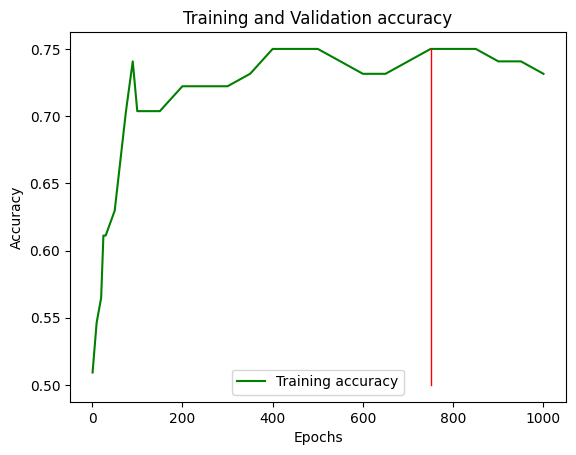

In [ ]:

plt.plot(epochs, accuracy, 'g', label='Training accuracy')
a = [750, 750]
b = [0.50, 0.750] 
plt.plot(a, b, color='r', linewidth=1) 

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 3)	 Modifique a taxa de aprendizado da Rede Neural. Escolha valores distintos (e.g. 0,001 e 0,1) e avalie os resultados.

#### Rascunho

Mantendo os parâmetros da questão anterior, com dados normalizados.

In [ ]:
X = new_df_normalized.values[:,:-1].astype('float')
target = new_df_normalized.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X.shape[1] #numero de neuronios de entradas
n_output = 1 #número de neurônios na camada de saida
batch_size = 32
binary = True

lr= [0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.015,0.02,0.025,0.030,0.035,0.040,0.045,0.05,0.055,0.060,0.065,0.070,0.075,0.080,0.085,0.090,0.095,0.1]
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')


In [ ]:
accuracy = []
precision = []
f1score = []
recall = []

for i in range(0,len(lr)):
  history, y_hat = train(model, train_loader, val_dataset, epochs=250, lr=lr[i], device=device, binary=binary)

  y_pred = model.predict(test_dataset.X_data,binary=binary)
  
  accuracy.append(accuracy_score(y_test, y_pred))
  precision.append(precision_score(y_test, y_pred,average='weighted'))
  f1score.append(f1_score(y_test, y_pred,average='weighted'))
  recall.append(recall_score(y_test, y_pred,average='weighted'))


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.708 | Val Loss: 0.7181 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 002: | Train Loss: 0.708 | Val Loss: 0.7180 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 003: | Train Loss: 0.708 | Val Loss: 0.7178 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 004: | Train Loss: 0.708 | Val Loss: 0.7176 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 005: | Train Loss: 0.708 | Val Loss: 0.7174 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 006: | Train Loss: 0.707 | Val Loss: 0.7172 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 007: | Train Loss: 0.707 | Val Loss: 0.7171 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 008: | Train Loss: 0.707 | Val Loss: 0.7169 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 009: | Train Loss: 0.707 | Val Loss: 0.7167 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 010: | Train Loss: 0.707 | Val Loss: 0.7166 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 011: | Train Loss: 0.706 | Val Loss: 0.7164 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 012: | Train Lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.685 | Val Loss: 0.6953 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 002: | Train Loss: 0.685 | Val Loss: 0.6953 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 003: | Train Loss: 0.684 | Val Loss: 0.6952 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 004: | Train Loss: 0.684 | Val Loss: 0.6951 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 005: | Train Loss: 0.684 | Val Loss: 0.6950 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 006: | Train Loss: 0.684 | Val Loss: 0.6950 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 007: | Train Loss: 0.684 | Val Loss: 0.6949 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 008: | Train Loss: 0.684 | Val Loss: 0.6948 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 009: | Train Loss: 0.684 | Val Loss: 0.6948 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 010: | Train Loss: 0.684 | Val Loss: 0.6947 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 011: | Train Loss: 0.684 | Val Loss: 0.6946 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.672 | Val Loss: 0.6865 | Train Acc: 70.4545| Val Acc: 63.0000
Epoch 002: | Train Loss: 0.671 | Val Loss: 0.6865 | Train Acc: 70.7273| Val Acc: 63.0000
Epoch 003: | Train Loss: 0.671 | Val Loss: 0.6864 | Train Acc: 70.1818| Val Acc: 63.0000
Epoch 004: | Train Loss: 0.671 | Val Loss: 0.6864 | Train Acc: 70.6364| Val Acc: 63.0000
Epoch 005: | Train Loss: 0.671 | Val Loss: 0.6863 | Train Acc: 71.0000| Val Acc: 63.0000
Epoch 006: | Train Loss: 0.671 | Val Loss: 0.6863 | Train Acc: 71.2727| Val Acc: 63.0000
Epoch 007: | Train Loss: 0.671 | Val Loss: 0.6863 | Train Acc: 71.2727| Val Acc: 63.0000
Epoch 008: | Train Loss: 0.671 | Val Loss: 0.6862 | Train Acc: 71.0000| Val Acc: 60.0000
Epoch 009: | Train Loss: 0.671 | Val Loss: 0.6862 | Train Acc: 71.0000| Val Acc: 60.0000
Epoch 010: | Train Loss: 0.671 | Val Loss: 0.6861 | Train Acc: 71.4545| Val Acc: 60.0000
Epoch 011: | Train Loss: 0.671 | Val Loss: 0.6861 | Train Acc: 71.4545| Val Acc: 60.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.641 | Val Loss: 0.6737 | Train Acc: 74.7273| Val Acc: 62.0000
Epoch 002: | Train Loss: 0.641 | Val Loss: 0.6736 | Train Acc: 74.7273| Val Acc: 62.0000
Epoch 003: | Train Loss: 0.641 | Val Loss: 0.6735 | Train Acc: 74.7273| Val Acc: 62.0000
Epoch 004: | Train Loss: 0.641 | Val Loss: 0.6735 | Train Acc: 74.7273| Val Acc: 62.0000
Epoch 005: | Train Loss: 0.641 | Val Loss: 0.6734 | Train Acc: 74.7273| Val Acc: 62.0000
Epoch 006: | Train Loss: 0.641 | Val Loss: 0.6733 | Train Acc: 74.7273| Val Acc: 62.0000
Epoch 007: | Train Loss: 0.640 | Val Loss: 0.6733 | Train Acc: 74.7273| Val Acc: 62.0000
Epoch 008: | Train Loss: 0.640 | Val Loss: 0.6732 | Train Acc: 74.7273| Val Acc: 62.0000
Epoch 009: | Train Loss: 0.640 | Val Loss: 0.6731 | Train Acc: 74.7273| Val Acc: 62.0000
Epoch 010: | Train Loss: 0.640 | Val Loss: 0.6730 | Train Acc: 74.7273| Val Acc: 62.0000
Epoch 011: | Train Loss: 0.640 | Val Loss: 0.6730 | Train Acc: 74.7273| Val Acc: 62.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.594 | Val Loss: 0.6568 | Train Acc: 73.0000| Val Acc: 62.0000
Epoch 002: | Train Loss: 0.594 | Val Loss: 0.6567 | Train Acc: 73.0000| Val Acc: 62.0000
Epoch 003: | Train Loss: 0.594 | Val Loss: 0.6566 | Train Acc: 73.0000| Val Acc: 62.0000
Epoch 004: | Train Loss: 0.593 | Val Loss: 0.6565 | Train Acc: 73.0000| Val Acc: 62.0000
Epoch 005: | Train Loss: 0.593 | Val Loss: 0.6565 | Train Acc: 73.0000| Val Acc: 62.0000
Epoch 006: | Train Loss: 0.593 | Val Loss: 0.6564 | Train Acc: 73.0000| Val Acc: 62.0000
Epoch 007: | Train Loss: 0.593 | Val Loss: 0.6563 | Train Acc: 73.0000| Val Acc: 62.0000
Epoch 008: | Train Loss: 0.593 | Val Loss: 0.6563 | Train Acc: 73.0000| Val Acc: 62.0000
Epoch 009: | Train Loss: 0.592 | Val Loss: 0.6562 | Train Acc: 73.0000| Val Acc: 62.0000
Epoch 010: | Train Loss: 0.592 | Val Loss: 0.6561 | Train Acc: 73.0000| Val Acc: 62.0000
Epoch 011: | Train Loss: 0.592 | Val Loss: 0.6561 | Train Acc: 73.0000| Val Acc: 62.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.555 | Val Loss: 0.6392 | Train Acc: 74.8182| Val Acc: 65.0000
Epoch 002: | Train Loss: 0.555 | Val Loss: 0.6392 | Train Acc: 74.8182| Val Acc: 65.0000
Epoch 003: | Train Loss: 0.555 | Val Loss: 0.6391 | Train Acc: 74.8182| Val Acc: 65.0000
Epoch 004: | Train Loss: 0.555 | Val Loss: 0.6390 | Train Acc: 74.8182| Val Acc: 65.0000
Epoch 005: | Train Loss: 0.555 | Val Loss: 0.6389 | Train Acc: 74.8182| Val Acc: 65.0000
Epoch 006: | Train Loss: 0.555 | Val Loss: 0.6388 | Train Acc: 74.8182| Val Acc: 65.0000
Epoch 007: | Train Loss: 0.555 | Val Loss: 0.6387 | Train Acc: 74.8182| Val Acc: 65.0000
Epoch 008: | Train Loss: 0.554 | Val Loss: 0.6387 | Train Acc: 74.8182| Val Acc: 65.0000
Epoch 009: | Train Loss: 0.554 | Val Loss: 0.6386 | Train Acc: 74.8182| Val Acc: 65.0000
Epoch 010: | Train Loss: 0.554 | Val Loss: 0.6385 | Train Acc: 74.8182| Val Acc: 65.0000
Epoch 011: | Train Loss: 0.554 | Val Loss: 0.6384 | Train Acc: 74.5455| Val Acc: 65.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.528 | Val Loss: 0.6138 | Train Acc: 75.7273| Val Acc: 65.0000
Epoch 002: | Train Loss: 0.528 | Val Loss: 0.6137 | Train Acc: 75.7273| Val Acc: 65.0000
Epoch 003: | Train Loss: 0.527 | Val Loss: 0.6136 | Train Acc: 75.7273| Val Acc: 65.0000
Epoch 004: | Train Loss: 0.527 | Val Loss: 0.6135 | Train Acc: 75.7273| Val Acc: 65.0000
Epoch 005: | Train Loss: 0.527 | Val Loss: 0.6134 | Train Acc: 75.7273| Val Acc: 65.0000
Epoch 006: | Train Loss: 0.527 | Val Loss: 0.6133 | Train Acc: 75.7273| Val Acc: 65.0000
Epoch 007: | Train Loss: 0.527 | Val Loss: 0.6132 | Train Acc: 75.7273| Val Acc: 65.0000
Epoch 008: | Train Loss: 0.527 | Val Loss: 0.6131 | Train Acc: 75.7273| Val Acc: 65.0000
Epoch 009: | Train Loss: 0.527 | Val Loss: 0.6130 | Train Acc: 75.7273| Val Acc: 65.0000
Epoch 010: | Train Loss: 0.527 | Val Loss: 0.6129 | Train Acc: 75.7273| Val Acc: 65.0000
Epoch 011: | Train Loss: 0.527 | Val Loss: 0.6128 | Train Acc: 75.7273| Val Acc: 65.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.509 | Val Loss: 0.5953 | Train Acc: 75.9091| Val Acc: 67.0000
Epoch 002: | Train Loss: 0.509 | Val Loss: 0.5953 | Train Acc: 75.9091| Val Acc: 67.0000
Epoch 003: | Train Loss: 0.509 | Val Loss: 0.5952 | Train Acc: 75.9091| Val Acc: 67.0000
Epoch 004: | Train Loss: 0.509 | Val Loss: 0.5952 | Train Acc: 75.9091| Val Acc: 67.0000
Epoch 005: | Train Loss: 0.509 | Val Loss: 0.5951 | Train Acc: 75.9091| Val Acc: 67.0000
Epoch 006: | Train Loss: 0.509 | Val Loss: 0.5951 | Train Acc: 75.9091| Val Acc: 67.0000
Epoch 007: | Train Loss: 0.509 | Val Loss: 0.5951 | Train Acc: 75.9091| Val Acc: 67.0000
Epoch 008: | Train Loss: 0.509 | Val Loss: 0.5950 | Train Acc: 75.9091| Val Acc: 67.0000
Epoch 009: | Train Loss: 0.509 | Val Loss: 0.5950 | Train Acc: 75.9091| Val Acc: 67.0000
Epoch 010: | Train Loss: 0.509 | Val Loss: 0.5950 | Train Acc: 75.9091| Val Acc: 67.0000
Epoch 011: | Train Loss: 0.509 | Val Loss: 0.5949 | Train Acc: 75.9091| Val Acc: 67.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.495 | Val Loss: 0.5888 | Train Acc: 76.7273| Val Acc: 65.0000
Epoch 002: | Train Loss: 0.495 | Val Loss: 0.5888 | Train Acc: 76.7273| Val Acc: 65.0000
Epoch 003: | Train Loss: 0.495 | Val Loss: 0.5888 | Train Acc: 76.7273| Val Acc: 65.0000
Epoch 004: | Train Loss: 0.495 | Val Loss: 0.5888 | Train Acc: 76.7273| Val Acc: 65.0000
Epoch 005: | Train Loss: 0.495 | Val Loss: 0.5888 | Train Acc: 76.7273| Val Acc: 65.0000
Epoch 006: | Train Loss: 0.495 | Val Loss: 0.5888 | Train Acc: 76.7273| Val Acc: 65.0000
Epoch 007: | Train Loss: 0.495 | Val Loss: 0.5888 | Train Acc: 76.7273| Val Acc: 65.0000
Epoch 008: | Train Loss: 0.495 | Val Loss: 0.5888 | Train Acc: 76.7273| Val Acc: 65.0000
Epoch 009: | Train Loss: 0.495 | Val Loss: 0.5887 | Train Acc: 76.7273| Val Acc: 65.0000
Epoch 010: | Train Loss: 0.495 | Val Loss: 0.5887 | Train Acc: 76.7273| Val Acc: 65.0000
Epoch 011: | Train Loss: 0.495 | Val Loss: 0.5887 | Train Acc: 76.7273| Val Acc: 65.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.486 | Val Loss: 0.5920 | Train Acc: 76.7273| Val Acc: 64.0000
Epoch 002: | Train Loss: 0.486 | Val Loss: 0.5921 | Train Acc: 76.7273| Val Acc: 64.0000
Epoch 003: | Train Loss: 0.486 | Val Loss: 0.5922 | Train Acc: 76.7273| Val Acc: 64.0000
Epoch 004: | Train Loss: 0.486 | Val Loss: 0.5921 | Train Acc: 76.7273| Val Acc: 64.0000
Epoch 005: | Train Loss: 0.486 | Val Loss: 0.5923 | Train Acc: 76.7273| Val Acc: 64.0000
Epoch 006: | Train Loss: 0.486 | Val Loss: 0.5923 | Train Acc: 76.7273| Val Acc: 64.0000
Epoch 007: | Train Loss: 0.486 | Val Loss: 0.5923 | Train Acc: 76.7273| Val Acc: 64.0000
Epoch 008: | Train Loss: 0.486 | Val Loss: 0.5924 | Train Acc: 76.7273| Val Acc: 64.0000
Epoch 009: | Train Loss: 0.486 | Val Loss: 0.5924 | Train Acc: 76.7273| Val Acc: 64.0000
Epoch 010: | Train Loss: 0.486 | Val Loss: 0.5924 | Train Acc: 76.7273| Val Acc: 64.0000
Epoch 011: | Train Loss: 0.486 | Val Loss: 0.5925 | Train Acc: 76.7273| Val Acc: 64.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.480 | Val Loss: 0.5951 | Train Acc: 77.2727| Val Acc: 67.0000
Epoch 002: | Train Loss: 0.480 | Val Loss: 0.5951 | Train Acc: 77.2727| Val Acc: 67.0000
Epoch 003: | Train Loss: 0.479 | Val Loss: 0.5946 | Train Acc: 77.0000| Val Acc: 67.0000
Epoch 004: | Train Loss: 0.479 | Val Loss: 0.5946 | Train Acc: 77.2727| Val Acc: 67.0000
Epoch 005: | Train Loss: 0.479 | Val Loss: 0.5943 | Train Acc: 77.2727| Val Acc: 67.0000
Epoch 006: | Train Loss: 0.479 | Val Loss: 0.5943 | Train Acc: 77.2727| Val Acc: 67.0000
Epoch 007: | Train Loss: 0.479 | Val Loss: 0.5943 | Train Acc: 77.2727| Val Acc: 67.0000
Epoch 008: | Train Loss: 0.479 | Val Loss: 0.5943 | Train Acc: 77.2727| Val Acc: 67.0000
Epoch 009: | Train Loss: 0.479 | Val Loss: 0.5943 | Train Acc: 77.2727| Val Acc: 67.0000
Epoch 010: | Train Loss: 0.479 | Val Loss: 0.5945 | Train Acc: 77.2727| Val Acc: 67.0000
Epoch 011: | Train Loss: 0.479 | Val Loss: 0.5944 | Train Acc: 77.2727| Val Acc: 67.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.474 | Val Loss: 0.5980 | Train Acc: 77.7273| Val Acc: 70.0000
Epoch 002: | Train Loss: 0.474 | Val Loss: 0.5980 | Train Acc: 77.7273| Val Acc: 70.0000
Epoch 003: | Train Loss: 0.474 | Val Loss: 0.5980 | Train Acc: 77.7273| Val Acc: 70.0000
Epoch 004: | Train Loss: 0.474 | Val Loss: 0.5980 | Train Acc: 77.7273| Val Acc: 70.0000
Epoch 005: | Train Loss: 0.474 | Val Loss: 0.5980 | Train Acc: 77.7273| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.474 | Val Loss: 0.5981 | Train Acc: 77.7273| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.474 | Val Loss: 0.5981 | Train Acc: 77.7273| Val Acc: 70.0000
Epoch 008: | Train Loss: 0.474 | Val Loss: 0.5981 | Train Acc: 77.7273| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.474 | Val Loss: 0.5981 | Train Acc: 77.7273| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.474 | Val Loss: 0.5981 | Train Acc: 77.7273| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.474 | Val Loss: 0.5982 | Train Acc: 77.7273| Val Acc: 70.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.470 | Val Loss: 0.6037 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 002: | Train Loss: 0.470 | Val Loss: 0.6037 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 003: | Train Loss: 0.470 | Val Loss: 0.6038 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 004: | Train Loss: 0.470 | Val Loss: 0.6047 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 005: | Train Loss: 0.470 | Val Loss: 0.6039 | Train Acc: 78.0000| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.470 | Val Loss: 0.6039 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.470 | Val Loss: 0.6040 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 008: | Train Loss: 0.470 | Val Loss: 0.6048 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.470 | Val Loss: 0.6039 | Train Acc: 77.6364| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.470 | Val Loss: 0.6048 | Train Acc: 77.9091| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.470 | Val Loss: 0.6040 | Train Acc: 78.0000| Val Acc: 70.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.467 | Val Loss: 0.6106 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 002: | Train Loss: 0.467 | Val Loss: 0.6105 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 003: | Train Loss: 0.467 | Val Loss: 0.6107 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 004: | Train Loss: 0.467 | Val Loss: 0.6106 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 005: | Train Loss: 0.467 | Val Loss: 0.6106 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 006: | Train Loss: 0.467 | Val Loss: 0.6108 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 007: | Train Loss: 0.467 | Val Loss: 0.6109 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 008: | Train Loss: 0.467 | Val Loss: 0.6116 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 009: | Train Loss: 0.467 | Val Loss: 0.6107 | Train Acc: 78.2727| Val Acc: 71.0000
Epoch 010: | Train Loss: 0.467 | Val Loss: 0.6116 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 011: | Train Loss: 0.467 | Val Loss: 0.6106 | Train Acc: 78.5455| Val Acc: 71.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.465 | Val Loss: 0.6212 | Train Acc: 78.8182| Val Acc: 71.0000
Epoch 002: | Train Loss: 0.465 | Val Loss: 0.6203 | Train Acc: 78.8182| Val Acc: 70.0000
Epoch 003: | Train Loss: 0.465 | Val Loss: 0.6211 | Train Acc: 78.8182| Val Acc: 70.0000
Epoch 004: | Train Loss: 0.465 | Val Loss: 0.6202 | Train Acc: 78.8182| Val Acc: 70.0000
Epoch 005: | Train Loss: 0.465 | Val Loss: 0.6207 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.465 | Val Loss: 0.6210 | Train Acc: 78.8182| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.465 | Val Loss: 0.6209 | Train Acc: 78.8182| Val Acc: 70.0000
Epoch 008: | Train Loss: 0.465 | Val Loss: 0.6209 | Train Acc: 78.8182| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.465 | Val Loss: 0.6208 | Train Acc: 78.8182| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.465 | Val Loss: 0.6210 | Train Acc: 78.8182| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.465 | Val Loss: 0.6211 | Train Acc: 78.8182| Val Acc: 70.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.463 | Val Loss: 0.6315 | Train Acc: 78.0000| Val Acc: 71.0000
Epoch 002: | Train Loss: 0.464 | Val Loss: 0.6308 | Train Acc: 78.0000| Val Acc: 71.0000
Epoch 003: | Train Loss: 0.463 | Val Loss: 0.6315 | Train Acc: 78.0000| Val Acc: 71.0000
Epoch 004: | Train Loss: 0.464 | Val Loss: 0.6308 | Train Acc: 78.0000| Val Acc: 71.0000
Epoch 005: | Train Loss: 0.463 | Val Loss: 0.6316 | Train Acc: 78.0000| Val Acc: 71.0000
Epoch 006: | Train Loss: 0.464 | Val Loss: 0.6308 | Train Acc: 78.2727| Val Acc: 71.0000
Epoch 007: | Train Loss: 0.464 | Val Loss: 0.6313 | Train Acc: 78.0000| Val Acc: 71.0000
Epoch 008: | Train Loss: 0.464 | Val Loss: 0.6312 | Train Acc: 78.2727| Val Acc: 71.0000
Epoch 009: | Train Loss: 0.464 | Val Loss: 0.6314 | Train Acc: 78.0000| Val Acc: 71.0000
Epoch 010: | Train Loss: 0.464 | Val Loss: 0.6314 | Train Acc: 78.0000| Val Acc: 71.0000
Epoch 011: | Train Loss: 0.464 | Val Loss: 0.6315 | Train Acc: 78.0000| Val Acc: 71.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.462 | Val Loss: 0.6404 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 002: | Train Loss: 0.463 | Val Loss: 0.6395 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 003: | Train Loss: 0.462 | Val Loss: 0.6403 | Train Acc: 78.0000| Val Acc: 70.0000
Epoch 004: | Train Loss: 0.463 | Val Loss: 0.6396 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 005: | Train Loss: 0.462 | Val Loss: 0.6405 | Train Acc: 78.0000| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.463 | Val Loss: 0.6404 | Train Acc: 78.0000| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.463 | Val Loss: 0.6397 | Train Acc: 78.0000| Val Acc: 70.0000
Epoch 008: | Train Loss: 0.463 | Val Loss: 0.6400 | Train Acc: 78.0000| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.463 | Val Loss: 0.6401 | Train Acc: 78.0000| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.462 | Val Loss: 0.6407 | Train Acc: 78.0000| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.462 | Val Loss: 0.6400 | Train Acc: 78.0000| Val Acc: 70.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.462 | Val Loss: 0.6486 | Train Acc: 79.0000| Val Acc: 70.0000
Epoch 002: | Train Loss: 0.462 | Val Loss: 0.6487 | Train Acc: 79.0000| Val Acc: 70.0000
Epoch 003: | Train Loss: 0.462 | Val Loss: 0.6487 | Train Acc: 79.0000| Val Acc: 70.0000
Epoch 004: | Train Loss: 0.462 | Val Loss: 0.6479 | Train Acc: 79.0000| Val Acc: 70.0000
Epoch 005: | Train Loss: 0.462 | Val Loss: 0.6486 | Train Acc: 79.0000| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.462 | Val Loss: 0.6487 | Train Acc: 79.0000| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.462 | Val Loss: 0.6479 | Train Acc: 79.0000| Val Acc: 70.0000
Epoch 008: | Train Loss: 0.462 | Val Loss: 0.6486 | Train Acc: 79.0000| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.462 | Val Loss: 0.6480 | Train Acc: 79.0000| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.462 | Val Loss: 0.6483 | Train Acc: 79.0000| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.462 | Val Loss: 0.6483 | Train Acc: 79.0000| Val Acc: 70.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.462 | Val Loss: 0.6577 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 002: | Train Loss: 0.462 | Val Loss: 0.6573 | Train Acc: 78.9091| Val Acc: 70.0000
Epoch 003: | Train Loss: 0.462 | Val Loss: 0.6575 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 004: | Train Loss: 0.462 | Val Loss: 0.6570 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 005: | Train Loss: 0.462 | Val Loss: 0.6577 | Train Acc: 78.9091| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.462 | Val Loss: 0.6570 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.462 | Val Loss: 0.6575 | Train Acc: 78.9091| Val Acc: 70.0000
Epoch 008: | Train Loss: 0.462 | Val Loss: 0.6573 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.462 | Val Loss: 0.6579 | Train Acc: 78.9091| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.462 | Val Loss: 0.6571 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.462 | Val Loss: 0.6574 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.462 | Val Loss: 0.6648 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 002: | Train Loss: 0.462 | Val Loss: 0.6650 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 003: | Train Loss: 0.462 | Val Loss: 0.6650 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 004: | Train Loss: 0.462 | Val Loss: 0.6642 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 005: | Train Loss: 0.462 | Val Loss: 0.6651 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.462 | Val Loss: 0.6641 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.462 | Val Loss: 0.6650 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 008: | Train Loss: 0.462 | Val Loss: 0.6649 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.463 | Val Loss: 0.6643 | Train Acc: 77.9091| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.462 | Val Loss: 0.6649 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.462 | Val Loss: 0.6643 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.462 | Val Loss: 0.6691 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 002: | Train Loss: 0.462 | Val Loss: 0.6692 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 003: | Train Loss: 0.462 | Val Loss: 0.6690 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 004: | Train Loss: 0.462 | Val Loss: 0.6689 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 005: | Train Loss: 0.462 | Val Loss: 0.6688 | Train Acc: 77.9091| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.462 | Val Loss: 0.6683 | Train Acc: 77.9091| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.462 | Val Loss: 0.6693 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 008: | Train Loss: 0.462 | Val Loss: 0.6688 | Train Acc: 77.9091| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.462 | Val Loss: 0.6692 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.462 | Val Loss: 0.6686 | Train Acc: 77.9091| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.462 | Val Loss: 0.6687 | Train Acc: 77.9091| Val Acc: 70.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.462 | Val Loss: 0.6715 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 002: | Train Loss: 0.462 | Val Loss: 0.6716 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 003: | Train Loss: 0.463 | Val Loss: 0.6707 | Train Acc: 77.9091| Val Acc: 70.0000
Epoch 004: | Train Loss: 0.463 | Val Loss: 0.6710 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 005: | Train Loss: 0.463 | Val Loss: 0.6712 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.462 | Val Loss: 0.6716 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.462 | Val Loss: 0.6712 | Train Acc: 77.9091| Val Acc: 70.0000
Epoch 008: | Train Loss: 0.462 | Val Loss: 0.6722 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.463 | Val Loss: 0.6712 | Train Acc: 77.9091| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.462 | Val Loss: 0.6722 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.462 | Val Loss: 0.6712 | Train Acc: 77.9091| Val Acc: 70.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.462 | Val Loss: 0.6728 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 002: | Train Loss: 0.462 | Val Loss: 0.6729 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 003: | Train Loss: 0.462 | Val Loss: 0.6728 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 004: | Train Loss: 0.462 | Val Loss: 0.6726 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 005: | Train Loss: 0.462 | Val Loss: 0.6719 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.463 | Val Loss: 0.6720 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.462 | Val Loss: 0.6730 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 008: | Train Loss: 0.462 | Val Loss: 0.6728 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.462 | Val Loss: 0.6721 | Train Acc: 77.9091| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.462 | Val Loss: 0.6724 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.462 | Val Loss: 0.6728 | Train Acc: 78.8182| Val Acc: 70.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.462 | Val Loss: 0.6732 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 002: | Train Loss: 0.462 | Val Loss: 0.6733 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 003: | Train Loss: 0.462 | Val Loss: 0.6727 | Train Acc: 77.9091| Val Acc: 70.0000
Epoch 004: | Train Loss: 0.462 | Val Loss: 0.6729 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 005: | Train Loss: 0.462 | Val Loss: 0.6730 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.462 | Val Loss: 0.6736 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.462 | Val Loss: 0.6733 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 008: | Train Loss: 0.462 | Val Loss: 0.6729 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.462 | Val Loss: 0.6734 | Train Acc: 78.8182| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.462 | Val Loss: 0.6732 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.462 | Val Loss: 0.6728 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.462 | Val Loss: 0.6735 | Train Acc: 78.2727| Val Acc: 70.0000
Epoch 002: | Train Loss: 0.462 | Val Loss: 0.6736 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 003: | Train Loss: 0.462 | Val Loss: 0.6737 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 004: | Train Loss: 0.462 | Val Loss: 0.6730 | Train Acc: 77.9091| Val Acc: 70.0000
Epoch 005: | Train Loss: 0.462 | Val Loss: 0.6732 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.462 | Val Loss: 0.6737 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.462 | Val Loss: 0.6731 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 008: | Train Loss: 0.462 | Val Loss: 0.6732 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.462 | Val Loss: 0.6741 | Train Acc: 78.5455| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.462 | Val Loss: 0.6732 | Train Acc: 77.9091| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.462 | Val Loss: 0.6734 | Train Acc: 78.1818| Val Acc: 70.0000
Epoch 012: | Train Lo

#### Resposta

O melhor resultado foi com a taxa de aprendizado de 0.025.

In [ ]:
resultado = dict(lr = lr, accuracy = accuracy, precision = precision, f1score = f1score, recall = recall)
resultado_df = pd.DataFrame(data=resultado)

In [ ]:
print(resultado_df)

       lr  accuracy  precision   f1score    recall
0   0.001  0.481481   0.231824  0.312963  0.481481
1   0.002  0.648148   0.670955  0.640416  0.648148
2   0.004  0.675926   0.678554  0.675787  0.675926
3   0.005  0.685185   0.685871  0.685293  0.685185
4   0.006  0.703704   0.703704  0.703704  0.703704
5   0.008  0.731481   0.734396  0.731366  0.731481
6   0.010  0.731481   0.732749  0.731551  0.731481
7   0.015  0.740741   0.744802  0.740474  0.740741
8   0.020  0.768519   0.769824  0.768578  0.768519
9   0.025  0.777778   0.778464  0.777854  0.777778
10  0.030  0.750000   0.749914  0.749893  0.750000
11  0.035  0.750000   0.749914  0.749893  0.750000
12  0.040  0.759259   0.759285  0.759011  0.759259
13  0.045  0.731481   0.731376  0.731366  0.731481
14  0.050  0.722222   0.722222  0.722222  0.722222
15  0.055  0.722222   0.722222  0.722222  0.722222
16  0.060  0.722222   0.722222  0.722222  0.722222
17  0.065  0.722222   0.722222  0.722222  0.722222
18  0.070  0.722222   0.722222 

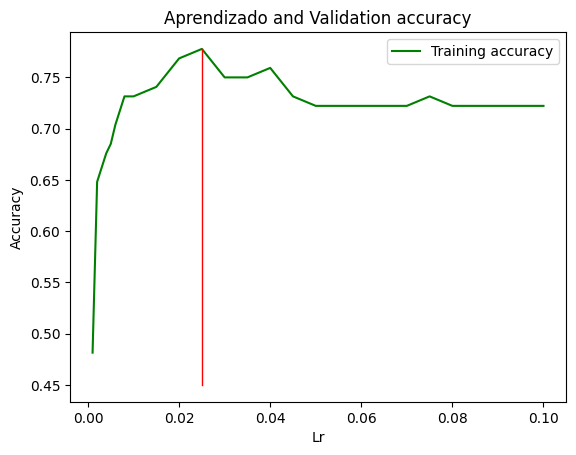

In [ ]:
plt.plot(lr, accuracy, 'g', label='Training accuracy')
a = [0.025, 0.025]
b = [0.45, 0.7777 ] 
plt.plot(a, b, color='r', linewidth=1) 

plt.title('Aprendizado and Validation accuracy')
plt.xlabel('Lr')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 4)	Modifique a quantidade de neurônios na camada escondida da Rede Neural. Escolha valores distintos (e.g. 2 e 70 neurônios) e avalie os resultados.

#### Rascunho

Mantendo os parâmetros da questão anterior com dados normalizados.

In [ ]:
epoch = 250
lr= 0.001
hidden_neurons = [2,5,10,15,20,25,30,35,40,45,50,55,60,65,70]


In [ ]:
X = new_df_normalized.values[:,:-1].astype('float')
target = new_df_normalized.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X.shape[1] #numero de neuronios de entradas
n_output = 1 #número de neurônios na camada de saida
batch_size = 32
binary = True

model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')

In [ ]:
accuracy = []
precision = []
f1score = []
recall = []

for i in range(0,len(hidden_neurons)):

  model = NeuralNetwork(hidden_neurons = hidden_neurons[i],n_input = n_input, n_output=n_output,output_activation='sigmoid')
  history, y_hat = train(model, train_loader, val_dataset, epochs=250, lr=lr, device=device, binary=binary)

  y_pred = model.predict(test_dataset.X_data,binary=binary)
  
  accuracy.append(accuracy_score(y_test, y_pred))
  precision.append(precision_score(y_test, y_pred,average='weighted'))
  f1score.append(f1_score(y_test, y_pred,average='weighted'))
  recall.append(recall_score(y_test, y_pred,average='weighted'))

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.703 | Val Loss: 0.7066 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 002: | Train Loss: 0.703 | Val Loss: 0.7066 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 003: | Train Loss: 0.703 | Val Loss: 0.7065 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 004: | Train Loss: 0.703 | Val Loss: 0.7065 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 005: | Train Loss: 0.703 | Val Loss: 0.7064 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 006: | Train Loss: 0.703 | Val Loss: 0.7063 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 007: | Train Loss: 0.703 | Val Loss: 0.7063 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 008: | Train Loss: 0.703 | Val Loss: 0.7062 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 009: | Train Loss: 0.703 | Val Loss: 0.7062 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 010: | Train Loss: 0.703 | Val Loss: 0.7061 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 011: | Train Loss: 0.703 | Val Loss: 0.7060 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 012: | Train Lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.699 | Val Loss: 0.6961 | Train Acc: 45.6364| Val Acc: 49.0000
Epoch 002: | Train Loss: 0.699 | Val Loss: 0.6961 | Train Acc: 45.6364| Val Acc: 49.0000
Epoch 003: | Train Loss: 0.699 | Val Loss: 0.6961 | Train Acc: 45.6364| Val Acc: 49.0000
Epoch 004: | Train Loss: 0.699 | Val Loss: 0.6961 | Train Acc: 45.6364| Val Acc: 49.0000
Epoch 005: | Train Loss: 0.699 | Val Loss: 0.6961 | Train Acc: 45.6364| Val Acc: 49.0000
Epoch 006: | Train Loss: 0.699 | Val Loss: 0.6961 | Train Acc: 45.3636| Val Acc: 49.0000
Epoch 007: | Train Loss: 0.699 | Val Loss: 0.6961 | Train Acc: 45.3636| Val Acc: 49.0000
Epoch 008: | Train Loss: 0.699 | Val Loss: 0.6961 | Train Acc: 45.3636| Val Acc: 49.0000
Epoch 009: | Train Loss: 0.699 | Val Loss: 0.6961 | Train Acc: 45.3636| Val Acc: 49.0000
Epoch 010: | Train Loss: 0.699 | Val Loss: 0.6961 | Train Acc: 45.3636| Val Acc: 48.0000
Epoch 011: | Train Loss: 0.699 | Val Loss: 0.6961 | Train Acc: 45.3636| Val Acc: 48.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.697 | Val Loss: 0.6923 | Train Acc: 48.8182| Val Acc: 52.0000
Epoch 002: | Train Loss: 0.697 | Val Loss: 0.6923 | Train Acc: 48.8182| Val Acc: 52.0000
Epoch 003: | Train Loss: 0.697 | Val Loss: 0.6923 | Train Acc: 48.8182| Val Acc: 52.0000
Epoch 004: | Train Loss: 0.697 | Val Loss: 0.6923 | Train Acc: 48.8182| Val Acc: 52.0000
Epoch 005: | Train Loss: 0.697 | Val Loss: 0.6923 | Train Acc: 48.8182| Val Acc: 52.0000
Epoch 006: | Train Loss: 0.697 | Val Loss: 0.6922 | Train Acc: 48.8182| Val Acc: 52.0000
Epoch 007: | Train Loss: 0.697 | Val Loss: 0.6922 | Train Acc: 48.8182| Val Acc: 52.0000
Epoch 008: | Train Loss: 0.697 | Val Loss: 0.6922 | Train Acc: 48.8182| Val Acc: 52.0000
Epoch 009: | Train Loss: 0.697 | Val Loss: 0.6922 | Train Acc: 48.8182| Val Acc: 52.0000
Epoch 010: | Train Loss: 0.697 | Val Loss: 0.6922 | Train Acc: 48.8182| Val Acc: 52.0000
Epoch 011: | Train Loss: 0.697 | Val Loss: 0.6921 | Train Acc: 48.5455| Val Acc: 52.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.698 | Val Loss: 0.7005 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 002: | Train Loss: 0.698 | Val Loss: 0.7005 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 003: | Train Loss: 0.698 | Val Loss: 0.7004 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 004: | Train Loss: 0.698 | Val Loss: 0.7004 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 005: | Train Loss: 0.698 | Val Loss: 0.7003 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 006: | Train Loss: 0.698 | Val Loss: 0.7003 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 007: | Train Loss: 0.698 | Val Loss: 0.7002 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 008: | Train Loss: 0.698 | Val Loss: 0.7002 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 009: | Train Loss: 0.698 | Val Loss: 0.7001 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 010: | Train Loss: 0.698 | Val Loss: 0.7001 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 011: | Train Loss: 0.698 | Val Loss: 0.7000 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 012: | Train Lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.699 | Val Loss: 0.6968 | Train Acc: 48.7273| Val Acc: 51.0000
Epoch 002: | Train Loss: 0.699 | Val Loss: 0.6968 | Train Acc: 48.7273| Val Acc: 51.0000
Epoch 003: | Train Loss: 0.699 | Val Loss: 0.6967 | Train Acc: 47.9091| Val Acc: 51.0000
Epoch 004: | Train Loss: 0.699 | Val Loss: 0.6967 | Train Acc: 47.9091| Val Acc: 51.0000
Epoch 005: | Train Loss: 0.699 | Val Loss: 0.6967 | Train Acc: 47.9091| Val Acc: 51.0000
Epoch 006: | Train Loss: 0.699 | Val Loss: 0.6967 | Train Acc: 48.2727| Val Acc: 51.0000
Epoch 007: | Train Loss: 0.699 | Val Loss: 0.6967 | Train Acc: 48.0000| Val Acc: 51.0000
Epoch 008: | Train Loss: 0.699 | Val Loss: 0.6967 | Train Acc: 48.0000| Val Acc: 51.0000
Epoch 009: | Train Loss: 0.699 | Val Loss: 0.6967 | Train Acc: 48.0000| Val Acc: 51.0000
Epoch 010: | Train Loss: 0.699 | Val Loss: 0.6967 | Train Acc: 48.2727| Val Acc: 51.0000
Epoch 011: | Train Loss: 0.699 | Val Loss: 0.6966 | Train Acc: 48.2727| Val Acc: 51.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.689 | Val Loss: 0.6869 | Train Acc: 50.3636| Val Acc: 50.0000
Epoch 002: | Train Loss: 0.689 | Val Loss: 0.6869 | Train Acc: 50.3636| Val Acc: 50.0000
Epoch 003: | Train Loss: 0.689 | Val Loss: 0.6869 | Train Acc: 50.3636| Val Acc: 50.0000
Epoch 004: | Train Loss: 0.689 | Val Loss: 0.6868 | Train Acc: 50.3636| Val Acc: 50.0000
Epoch 005: | Train Loss: 0.689 | Val Loss: 0.6868 | Train Acc: 50.3636| Val Acc: 50.0000
Epoch 006: | Train Loss: 0.689 | Val Loss: 0.6868 | Train Acc: 50.3636| Val Acc: 50.0000
Epoch 007: | Train Loss: 0.689 | Val Loss: 0.6868 | Train Acc: 50.3636| Val Acc: 50.0000
Epoch 008: | Train Loss: 0.689 | Val Loss: 0.6868 | Train Acc: 50.3636| Val Acc: 50.0000
Epoch 009: | Train Loss: 0.689 | Val Loss: 0.6868 | Train Acc: 50.3636| Val Acc: 50.0000
Epoch 010: | Train Loss: 0.689 | Val Loss: 0.6868 | Train Acc: 50.3636| Val Acc: 50.0000
Epoch 011: | Train Loss: 0.689 | Val Loss: 0.6868 | Train Acc: 50.3636| Val Acc: 50.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.700 | Val Loss: 0.6949 | Train Acc: 41.0000| Val Acc: 49.0000
Epoch 002: | Train Loss: 0.700 | Val Loss: 0.6948 | Train Acc: 41.3636| Val Acc: 49.0000
Epoch 003: | Train Loss: 0.700 | Val Loss: 0.6948 | Train Acc: 41.3636| Val Acc: 48.0000
Epoch 004: | Train Loss: 0.700 | Val Loss: 0.6948 | Train Acc: 40.6364| Val Acc: 48.0000
Epoch 005: | Train Loss: 0.700 | Val Loss: 0.6948 | Train Acc: 40.6364| Val Acc: 48.0000
Epoch 006: | Train Loss: 0.700 | Val Loss: 0.6948 | Train Acc: 40.6364| Val Acc: 48.0000
Epoch 007: | Train Loss: 0.700 | Val Loss: 0.6948 | Train Acc: 40.6364| Val Acc: 48.0000
Epoch 008: | Train Loss: 0.700 | Val Loss: 0.6948 | Train Acc: 40.3636| Val Acc: 48.0000
Epoch 009: | Train Loss: 0.699 | Val Loss: 0.6947 | Train Acc: 40.3636| Val Acc: 48.0000
Epoch 010: | Train Loss: 0.699 | Val Loss: 0.6947 | Train Acc: 41.0000| Val Acc: 49.0000
Epoch 011: | Train Loss: 0.699 | Val Loss: 0.6947 | Train Acc: 41.2727| Val Acc: 49.0000
Epoch 012: | Train Lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.697 | Val Loss: 0.6932 | Train Acc: 50.0000| Val Acc: 57.0000
Epoch 002: | Train Loss: 0.697 | Val Loss: 0.6932 | Train Acc: 49.7273| Val Acc: 57.0000
Epoch 003: | Train Loss: 0.697 | Val Loss: 0.6932 | Train Acc: 49.7273| Val Acc: 57.0000
Epoch 004: | Train Loss: 0.697 | Val Loss: 0.6932 | Train Acc: 50.0000| Val Acc: 56.0000
Epoch 005: | Train Loss: 0.697 | Val Loss: 0.6931 | Train Acc: 50.0000| Val Acc: 56.0000
Epoch 006: | Train Loss: 0.697 | Val Loss: 0.6931 | Train Acc: 49.7273| Val Acc: 56.0000
Epoch 007: | Train Loss: 0.697 | Val Loss: 0.6931 | Train Acc: 50.3636| Val Acc: 56.0000
Epoch 008: | Train Loss: 0.697 | Val Loss: 0.6931 | Train Acc: 50.0909| Val Acc: 56.0000
Epoch 009: | Train Loss: 0.697 | Val Loss: 0.6930 | Train Acc: 50.3636| Val Acc: 56.0000
Epoch 010: | Train Loss: 0.697 | Val Loss: 0.6930 | Train Acc: 50.3636| Val Acc: 56.0000
Epoch 011: | Train Loss: 0.697 | Val Loss: 0.6930 | Train Acc: 50.6364| Val Acc: 55.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.706 | Val Loss: 0.7223 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 002: | Train Loss: 0.706 | Val Loss: 0.7219 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 003: | Train Loss: 0.705 | Val Loss: 0.7214 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 004: | Train Loss: 0.705 | Val Loss: 0.7209 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 005: | Train Loss: 0.705 | Val Loss: 0.7205 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 006: | Train Loss: 0.704 | Val Loss: 0.7201 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 007: | Train Loss: 0.704 | Val Loss: 0.7196 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 008: | Train Loss: 0.704 | Val Loss: 0.7192 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 009: | Train Loss: 0.703 | Val Loss: 0.7188 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 010: | Train Loss: 0.703 | Val Loss: 0.7184 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 011: | Train Loss: 0.703 | Val Loss: 0.7180 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 012: | Train Lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.702 | Val Loss: 0.7115 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 002: | Train Loss: 0.702 | Val Loss: 0.7113 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 003: | Train Loss: 0.701 | Val Loss: 0.7111 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 004: | Train Loss: 0.701 | Val Loss: 0.7109 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 005: | Train Loss: 0.701 | Val Loss: 0.7108 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 006: | Train Loss: 0.701 | Val Loss: 0.7106 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 007: | Train Loss: 0.701 | Val Loss: 0.7104 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 008: | Train Loss: 0.701 | Val Loss: 0.7102 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 009: | Train Loss: 0.701 | Val Loss: 0.7100 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 010: | Train Loss: 0.700 | Val Loss: 0.7099 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 011: | Train Loss: 0.700 | Val Loss: 0.7097 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 012: | Train Lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.693 | Val Loss: 0.6897 | Train Acc: 49.9091| Val Acc: 50.0000
Epoch 002: | Train Loss: 0.693 | Val Loss: 0.6897 | Train Acc: 50.1818| Val Acc: 50.0000
Epoch 003: | Train Loss: 0.693 | Val Loss: 0.6896 | Train Acc: 50.1818| Val Acc: 50.0000
Epoch 004: | Train Loss: 0.693 | Val Loss: 0.6896 | Train Acc: 50.1818| Val Acc: 50.0000
Epoch 005: | Train Loss: 0.692 | Val Loss: 0.6895 | Train Acc: 50.4545| Val Acc: 50.0000
Epoch 006: | Train Loss: 0.692 | Val Loss: 0.6895 | Train Acc: 50.7273| Val Acc: 50.0000
Epoch 007: | Train Loss: 0.692 | Val Loss: 0.6894 | Train Acc: 51.2727| Val Acc: 50.0000
Epoch 008: | Train Loss: 0.692 | Val Loss: 0.6894 | Train Acc: 51.2727| Val Acc: 50.0000
Epoch 009: | Train Loss: 0.692 | Val Loss: 0.6893 | Train Acc: 51.2727| Val Acc: 49.0000
Epoch 010: | Train Loss: 0.692 | Val Loss: 0.6893 | Train Acc: 52.0909| Val Acc: 49.0000
Epoch 011: | Train Loss: 0.692 | Val Loss: 0.6892 | Train Acc: 52.3636| Val Acc: 50.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.702 | Val Loss: 0.7023 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 002: | Train Loss: 0.702 | Val Loss: 0.7021 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 003: | Train Loss: 0.702 | Val Loss: 0.7020 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 004: | Train Loss: 0.702 | Val Loss: 0.7019 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 005: | Train Loss: 0.702 | Val Loss: 0.7017 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 006: | Train Loss: 0.702 | Val Loss: 0.7016 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 007: | Train Loss: 0.701 | Val Loss: 0.7015 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 008: | Train Loss: 0.701 | Val Loss: 0.7013 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 009: | Train Loss: 0.701 | Val Loss: 0.7012 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 010: | Train Loss: 0.701 | Val Loss: 0.7011 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 011: | Train Loss: 0.701 | Val Loss: 0.7010 | Train Acc: 50.3636| Val Acc: 49.0000
Epoch 012: | Train Lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.703 | Val Loss: 0.6949 | Train Acc: 31.3636| Val Acc: 41.0000
Epoch 002: | Train Loss: 0.703 | Val Loss: 0.6949 | Train Acc: 30.7273| Val Acc: 41.0000
Epoch 003: | Train Loss: 0.703 | Val Loss: 0.6948 | Train Acc: 31.0909| Val Acc: 40.0000
Epoch 004: | Train Loss: 0.703 | Val Loss: 0.6948 | Train Acc: 31.3636| Val Acc: 40.0000
Epoch 005: | Train Loss: 0.703 | Val Loss: 0.6948 | Train Acc: 31.0909| Val Acc: 38.0000
Epoch 006: | Train Loss: 0.703 | Val Loss: 0.6947 | Train Acc: 30.8182| Val Acc: 38.0000
Epoch 007: | Train Loss: 0.703 | Val Loss: 0.6947 | Train Acc: 31.4545| Val Acc: 37.0000
Epoch 008: | Train Loss: 0.703 | Val Loss: 0.6947 | Train Acc: 30.8182| Val Acc: 38.0000
Epoch 009: | Train Loss: 0.703 | Val Loss: 0.6947 | Train Acc: 30.6364| Val Acc: 38.0000
Epoch 010: | Train Loss: 0.703 | Val Loss: 0.6946 | Train Acc: 31.0909| Val Acc: 40.0000
Epoch 011: | Train Loss: 0.703 | Val Loss: 0.6946 | Train Acc: 31.3636| Val Acc: 40.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.689 | Val Loss: 0.6902 | Train Acc: 64.0000| Val Acc: 58.0000
Epoch 002: | Train Loss: 0.689 | Val Loss: 0.6902 | Train Acc: 64.3636| Val Acc: 56.0000
Epoch 003: | Train Loss: 0.689 | Val Loss: 0.6902 | Train Acc: 61.9091| Val Acc: 57.0000
Epoch 004: | Train Loss: 0.689 | Val Loss: 0.6901 | Train Acc: 61.6364| Val Acc: 56.0000
Epoch 005: | Train Loss: 0.689 | Val Loss: 0.6901 | Train Acc: 60.7273| Val Acc: 56.0000
Epoch 006: | Train Loss: 0.689 | Val Loss: 0.6901 | Train Acc: 60.8182| Val Acc: 55.0000
Epoch 007: | Train Loss: 0.689 | Val Loss: 0.6901 | Train Acc: 60.6364| Val Acc: 56.0000
Epoch 008: | Train Loss: 0.688 | Val Loss: 0.6900 | Train Acc: 60.9091| Val Acc: 56.0000
Epoch 009: | Train Loss: 0.688 | Val Loss: 0.6900 | Train Acc: 62.4545| Val Acc: 57.0000
Epoch 010: | Train Loss: 0.688 | Val Loss: 0.6900 | Train Acc: 62.4545| Val Acc: 56.0000
Epoch 011: | Train Loss: 0.688 | Val Loss: 0.6899 | Train Acc: 61.6364| Val Acc: 56.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.692 | Val Loss: 0.6938 | Train Acc: 49.6364| Val Acc: 49.0000
Epoch 002: | Train Loss: 0.692 | Val Loss: 0.6938 | Train Acc: 49.6364| Val Acc: 49.0000
Epoch 003: | Train Loss: 0.692 | Val Loss: 0.6938 | Train Acc: 49.6364| Val Acc: 49.0000
Epoch 004: | Train Loss: 0.692 | Val Loss: 0.6938 | Train Acc: 49.6364| Val Acc: 49.0000
Epoch 005: | Train Loss: 0.692 | Val Loss: 0.6938 | Train Acc: 49.6364| Val Acc: 49.0000
Epoch 006: | Train Loss: 0.692 | Val Loss: 0.6937 | Train Acc: 49.6364| Val Acc: 49.0000
Epoch 007: | Train Loss: 0.692 | Val Loss: 0.6937 | Train Acc: 49.6364| Val Acc: 49.0000
Epoch 008: | Train Loss: 0.692 | Val Loss: 0.6937 | Train Acc: 49.6364| Val Acc: 49.0000
Epoch 009: | Train Loss: 0.692 | Val Loss: 0.6937 | Train Acc: 49.6364| Val Acc: 49.0000
Epoch 010: | Train Loss: 0.692 | Val Loss: 0.6937 | Train Acc: 49.6364| Val Acc: 49.0000
Epoch 011: | Train Loss: 0.692 | Val Loss: 0.6937 | Train Acc: 49.6364| Val Acc: 49.0000
Epoch 012: | Train Lo

#### Resposta

Quando aumentamos o número de neurônios, não melhora diretamente a acurácia.
Melhor resultado foram com 35 neurônios na camada escondida.

In [ ]:
resultado = dict(hidden_neurons = hidden_neurons, accuracy = accuracy, precision = precision, f1score = f1score, recall = recall)
resultado_df = pd.DataFrame(data=resultado)

In [ ]:
print(resultado_df)

    hidden_neurons  accuracy  precision   f1score    recall
0                2  0.481481   0.231824  0.312963  0.481481
1                5  0.416667   0.353038  0.356037  0.416667
2               10  0.509259   0.543106  0.445090  0.509259
3               15  0.481481   0.231824  0.312963  0.481481
4               20  0.435185   0.407429  0.369971  0.435185
5               25  0.546296   0.708941  0.452874  0.546296
6               30  0.481481   0.231824  0.312963  0.481481
7               35  0.564815   0.650482  0.507910  0.564815
8               40  0.481481   0.231824  0.312963  0.481481
9               45  0.481481   0.231824  0.312963  0.481481
10              50  0.500000   0.754717  0.352684  0.500000
11              55  0.481481   0.231824  0.312963  0.481481
12              60  0.527778   0.687569  0.419753  0.527778
13              65  0.527778   0.687569  0.419753  0.527778
14              70  0.444444   0.222222  0.296296  0.444444


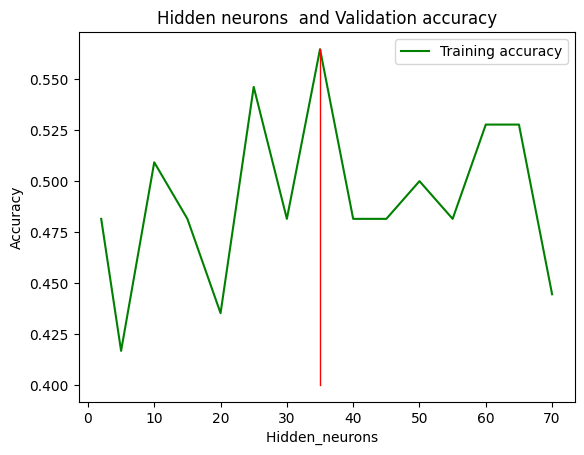

In [ ]:
plt.plot(hidden_neurons , accuracy, 'g', label='Training accuracy')
a = [35, 35]
b = [0.40, 0.565 ] 
plt.plot(a, b, color='r', linewidth=1) 

plt.title('Hidden neurons  and Validation accuracy')
plt.xlabel('Hidden_neurons  ')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Parte IV - Usando outras técnicas para Redes Neurais 
Total: 3,0 pts.

### 1)	Implemente a técnica de parada antecipada (Early Stopping) usando o conjunto de validação. Avalie o resultado obtido.

OBS: para essa questão, copie a função `train` do arquivo `model_utils.py`, copie neste notebook e faça as adaptações necessárias.

#### Rascunho

In [ ]:
import torch.nn as nn
from tqdm.notebook import tqdm
import torch
import numpy as np
from metrics import *
from typing import Tuple, Dict, List

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def evaluate(model: torch.nn.Module, val_set: Tuple[torch.tensor, torch.tensor], 
            criterion: torch.nn.Module, binary:bool =True) -> Tuple[torch.tensor, float, float]:
    """
    Evaluates a Pytorch model on a given dataset.
    Parameters:
    model (torch.nn.Module): The model to be evaluated
    data (tuple): A tuple containing the data and labels
    criterion (torch.nn.Module): The loss function to be used
    binary (bool): Boolean indicating whether the task is binary classification or not. Default: True
    Returns:
    tuple: A tuple containing predicted labels, loss, and accuracy
    """
    
    X = val_set.X_data
    y = val_set.y_data
    
    with torch.no_grad():
        y_pred = model(X)
    loss = criterion(y_pred, y)
    if binary:
        acc = binary_acc(y_pred, y)
    else:
        acc = accuracy(y_pred, y)
    y_pred = torch.argmax(y_pred, dim=1)

    return y_pred, loss.item(), acc.item()

In [ ]:
def Mytrain(model: torch.nn.Module , train_loader: torch.utils.data.DataLoader, 
         val_set: Tuple[torch.Tensor, torch.Tensor], epochs: int, device: torch.device, 
         lr: float, binary: bool = True, skip: int = 1) -> Tuple[Dict[str, List[float]], torch.Tensor]:
    """
    Trains a Pytorch model on a given training data.

    Parameters:
    model (torch.nn.Module): The model to be trained
    train_loader (DataLoader): The training data in the form of a Pytorch DataLoader
    val_set (tuple): A tuple containing the validation data and labels
    epochs (int): The number of times the training data should be passed through the model
    device (str or torch.device): The device on which to perform the computations (e.g. 'cpu' or 'cuda')
    lr (float): The learning rate for the optimizer
    binary (bool): Boolean indicating whether the task is binary classification or not. Default: True
    skip (int): The number of epochs after which the training and validation results will be printed. Default: 1

    Returns:
    tuple: A tuple containing the training history and the predicted labels after training
    """

    early_stopping = EarlyStopping(patience=5,verbose=True)
     
    if binary:
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()

    print('my train')
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    history = {'acc_train' : [], 'loss_train': [], 'acc_val': [], 'loss_val': []}

    for e in tqdm(range(1, epochs+1)):

        y_hat = np.array([])

        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X, y = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
            
            y_pred = model(X)
            
            loss = criterion(y_pred, y)
            if binary:
                acc = binary_acc(y_pred,y)
            else:
                acc = accuracy(y_pred, y)
            
            loss.backward()
            optimizer.step()
            
            train_epoch_loss += loss.item()
            train_epoch_acc += acc.item()
            y_p = torch.argmax(y_pred, dim=1)
            y_hat = np.concatenate((y_hat, y_p))


        model.eval()
        _, val_loss, val_acc = evaluate(model, val_set, criterion, binary=binary)

        history['acc_train'].append(train_epoch_acc/len(train_loader))
        history['loss_train'].append(train_epoch_loss/len(train_loader))
        history['acc_val'].append(val_acc)
        history['loss_val'].append(val_loss)


        #Earling Stopping encontrado
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
          print("Early stopping")
          break

        if e%skip == 0:
            print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.3f} | Val Loss: {val_loss:.4f} | Train Acc: {train_epoch_acc/len(train_loader):.4f}| Val Acc: {val_acc:.4f}')
    return history, y_hat

Inicializando os parametros

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
#Os dados de entrada não foram normalizados como solicitado no enunciado
new_df_normalized = transform_data(dataset, normalize=True)

In [ ]:
display(new_df_normalized)

preg      plas      pres      skin      insu      mass      pedi  \
0    0.176471  0.422111  0.596491  0.303030  0.125296  0.475410  0.216702   
1    0.294118  0.442211  0.578947  0.212121  0.027187  0.363636  0.110064   
2    0.058824  0.442211  0.263158  0.424242  0.117021  0.819672  0.176017   
3    0.058824  0.758794  0.526316  0.000000  0.000000  0.388972  0.040257   
4    0.176471  0.557789  0.543860  0.000000  0.000000  0.336811  0.024411   
..        ...       ...       ...       ...       ...       ...       ...   
531  0.000000  0.904523  0.684211  0.636364  0.016548  0.885246  1.000000   
532  0.705882  0.703518  0.719298  0.434343  0.384161  0.584203  0.189722   
533  0.117647  0.723618  0.508772  0.333333  0.159574  0.470939  0.144325   
534  0.411765  0.974874  0.596491  0.282828  0.000000  0.535022  0.282655   
535  0.176471  0.412060  0.614035  0.000000  0.000000  0.314456  0.130193   

          age           target  
0    0.066667  tested_negative  
1    0.150000  tested_negative  
2    0.083333  tested_positive  
3    0.016667  tested_negative  
4    0.000000  tested_negative  
..        ...              ...  
531  0.066667  tested_positive  
532  0.616667  tested_positive  
533  0.066667  tested_positive  
534  0.333333  tested_positive  
535  0.066667  tested_negative  

[536 rows x 9 columns]

In [ ]:
X = new_df_normalized.values[:,:-1].astype('float')
target = new_df_normalized.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X.shape[1] #numero de neuronios de entradas
n_output = 1 #número de neurônios na camada de saida
batch_size = 32
binary = True



In [ ]:
myModel = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = Mytrain(myModel, train_loader, val_dataset, epochs=2000, lr=0.01, device=device, binary=True)

my train


  0%|          | 0/2000 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.705744).  Saving model ...
Epoch 001: | Train Loss: 0.714 | Val Loss: 0.7057 | Train Acc: 49.6364| Val Acc: 51.0000
Validation loss decreased (0.705744 --> 0.704892).  Saving model ...
Epoch 002: | Train Loss: 0.713 | Val Loss: 0.7049 | Train Acc: 49.6364| Val Acc: 51.0000
Validation loss decreased (0.704892 --> 0.704093).  Saving model ...
Epoch 003: | Train Loss: 0.712 | Val Loss: 0.7041 | Train Acc: 49.6364| Val Acc: 51.0000
Validation loss decreased (0.704093 --> 0.703341).  Saving model ...
Epoch 004: | Train Loss: 0.711 | Val Loss: 0.7033 | Train Acc: 49.6364| Val Acc: 51.0000
Validation loss decreased (0.703341 --> 0.702632).  Saving model ...
Epoch 005: | Train Loss: 0.710 | Val Loss: 0.7026 | Train Acc: 49.6364| Val Acc: 51.0000
Validation loss decreased (0.702632 --> 0.701961).  Saving model ...
Epoch 006: | Train Loss: 0.709 | Val Loss: 0.7020 | Train Acc: 49.6364| Val Acc: 51.0000
Validation loss decreased (0.701961 --> 0.701330).  Savin

#### Resposta

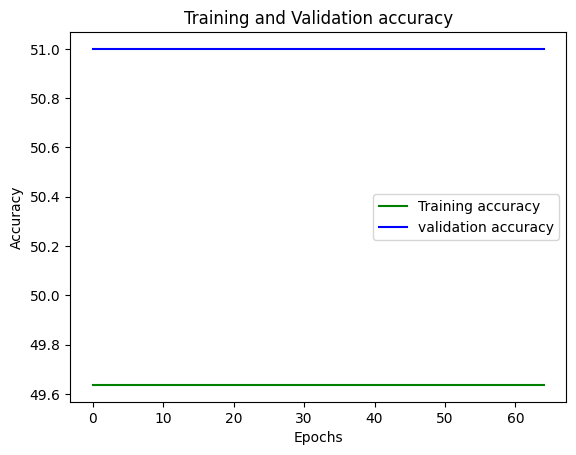

In [ ]:
acc_train = history['acc_train']
acc_val = history['acc_val']
ep = range(0,len(acc_val))
plt.plot(ep, acc_train, 'g', label='Training accuracy')
plt.plot(ep, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 2)	Faça novos testes para avaliar o desempenho da Rede Neural no problema designado usando a técnica K-Fold (com K = 10). Comente o resultado obtido.

Dica: não é necessário utilizar a ferramenta KFold do scikit-learn para o desenvolvimento deste item. Uma alternativa <b> simples </b> é fazer um *for loop*, selecionando os índices em bloco. 

#### Rascunho

In [ ]:
# Importa os pacotes
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [ ]:
# Garante a reproducividade do código
seed = 7
np.random.seed(seed)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
test_loader = DataLoader(dataset=test_dataset, batch_size=1)


#Arquitetura não muda
model = NeuralNetwork(n_input = n_input, n_output=n_output,hidden_neurons=15, output_activation='sigmoid')

In [ ]:
#skf = StratifiedKFold(n_splits=10)
#skf.get_n_splits(X, y)


# Define a validação cruzada
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
kfold.get_n_splits(X, y)

10

In [ ]:
# Cria um modelo para cada k-fold
cvscores = []
acuracia = []
precision = []
recall = []
resultado_df  = []

   

for i, (train_index, val_index) in enumerate(kfold.split(X, y)):
   print(i)
   #uma parte para treino
   X_train = X[train_index]
   y_train = y[train_index]
   
   #nove parte para validacao
   X_val = X[val_index]
   y_val = y[val_index]
   
   train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
   val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
   
   train_loader = DataLoader(dataset=train_dataset,batch_size=1)
   val_loader = DataLoader(dataset=val_dataset, batch_size=1)
 
   history, y_hat = train(model, train_loader, val_dataset, epochs=20, lr=lr, device=device, binary=binary)
   y_pred = model.predict(test_dataset.X_data,binary=True)

   acuracia.append(accuracy_score(y_test, y_pred))
   precision.append(precision_score(y_test, y_pred,average='weighted'))
   cvscores.append(f1_score(y_test, y_pred,average='weighted'))
   recall.append(recall_score(y_test, y_pred,average='weighted'))

   resultado = dict(accuracy = acuracia, precision = precision, f1score = cvscores, recall = recall)
   resultado_df = pd.DataFrame(data=resultado)
    
  


0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.693 | Val Loss: 0.6943 | Train Acc: 50.0000| Val Acc: 50.0000
Epoch 002: | Train Loss: 0.692 | Val Loss: 0.6927 | Train Acc: 50.0000| Val Acc: 50.0000
Epoch 003: | Train Loss: 0.690 | Val Loss: 0.6914 | Train Acc: 50.0000| Val Acc: 50.0000
Epoch 004: | Train Loss: 0.689 | Val Loss: 0.6903 | Train Acc: 50.0000| Val Acc: 50.0000
Epoch 005: | Train Loss: 0.688 | Val Loss: 0.6894 | Train Acc: 50.0000| Val Acc: 50.0000
Epoch 006: | Train Loss: 0.687 | Val Loss: 0.6885 | Train Acc: 50.0000| Val Acc: 50.0000
Epoch 007: | Train Loss: 0.686 | Val Loss: 0.6876 | Train Acc: 50.2075| Val Acc: 50.0000
Epoch 008: | Train Loss: 0.685 | Val Loss: 0.6868 | Train Acc: 51.0373| Val Acc: 52.0000
Epoch 009: | Train Loss: 0.684 | Val Loss: 0.6859 | Train Acc: 51.8672| Val Acc: 52.0000
Epoch 010: | Train Loss: 0.683 | Val Loss: 0.6851 | Train Acc: 53.5270| Val Acc: 52.0000
Epoch 011: | Train Loss: 0.683 | Val Loss: 0.6842 | Train Acc: 54.9793| Val Acc: 56.0000
Epoch 012: | Train Lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.673 | Val Loss: 0.6729 | Train Acc: 68.2573| Val Acc: 57.0000
Epoch 002: | Train Loss: 0.672 | Val Loss: 0.6722 | Train Acc: 68.6722| Val Acc: 59.0000
Epoch 003: | Train Loss: 0.671 | Val Loss: 0.6714 | Train Acc: 69.5021| Val Acc: 59.0000
Epoch 004: | Train Loss: 0.670 | Val Loss: 0.6707 | Train Acc: 69.7095| Val Acc: 59.0000
Epoch 005: | Train Loss: 0.669 | Val Loss: 0.6699 | Train Acc: 70.1245| Val Acc: 61.0000
Epoch 006: | Train Loss: 0.668 | Val Loss: 0.6691 | Train Acc: 70.9544| Val Acc: 61.0000
Epoch 007: | Train Loss: 0.666 | Val Loss: 0.6683 | Train Acc: 71.1618| Val Acc: 59.0000
Epoch 008: | Train Loss: 0.665 | Val Loss: 0.6675 | Train Acc: 71.1618| Val Acc: 59.0000
Epoch 009: | Train Loss: 0.664 | Val Loss: 0.6667 | Train Acc: 71.1618| Val Acc: 59.0000
Epoch 010: | Train Loss: 0.663 | Val Loss: 0.6659 | Train Acc: 71.7842| Val Acc: 57.0000
Epoch 011: | Train Loss: 0.662 | Val Loss: 0.6650 | Train Acc: 72.1992| Val Acc: 57.0000
Epoch 012: | Train Lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.648 | Val Loss: 0.6522 | Train Acc: 72.8216| Val Acc: 69.0000
Epoch 002: | Train Loss: 0.647 | Val Loss: 0.6509 | Train Acc: 73.0290| Val Acc: 69.0000
Epoch 003: | Train Loss: 0.645 | Val Loss: 0.6496 | Train Acc: 73.0290| Val Acc: 69.0000
Epoch 004: | Train Loss: 0.644 | Val Loss: 0.6483 | Train Acc: 73.4440| Val Acc: 69.0000
Epoch 005: | Train Loss: 0.642 | Val Loss: 0.6469 | Train Acc: 73.4440| Val Acc: 69.0000
Epoch 006: | Train Loss: 0.641 | Val Loss: 0.6455 | Train Acc: 73.6515| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.640 | Val Loss: 0.6441 | Train Acc: 74.0664| Val Acc: 72.0000
Epoch 008: | Train Loss: 0.638 | Val Loss: 0.6426 | Train Acc: 73.8589| Val Acc: 72.0000
Epoch 009: | Train Loss: 0.637 | Val Loss: 0.6412 | Train Acc: 73.2365| Val Acc: 72.0000
Epoch 010: | Train Loss: 0.635 | Val Loss: 0.6398 | Train Acc: 73.2365| Val Acc: 72.0000
Epoch 011: | Train Loss: 0.634 | Val Loss: 0.6383 | Train Acc: 74.2739| Val Acc: 72.0000
Epoch 012: | Train Lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.620 | Val Loss: 0.6079 | Train Acc: 73.8589| Val Acc: 72.0000
Epoch 002: | Train Loss: 0.619 | Val Loss: 0.6062 | Train Acc: 74.0664| Val Acc: 72.0000
Epoch 003: | Train Loss: 0.617 | Val Loss: 0.6045 | Train Acc: 73.6515| Val Acc: 74.0000
Epoch 004: | Train Loss: 0.616 | Val Loss: 0.6028 | Train Acc: 73.6515| Val Acc: 74.0000
Epoch 005: | Train Loss: 0.614 | Val Loss: 0.6011 | Train Acc: 73.6515| Val Acc: 74.0000
Epoch 006: | Train Loss: 0.613 | Val Loss: 0.5994 | Train Acc: 73.4440| Val Acc: 76.0000
Epoch 007: | Train Loss: 0.611 | Val Loss: 0.5977 | Train Acc: 73.6515| Val Acc: 76.0000
Epoch 008: | Train Loss: 0.610 | Val Loss: 0.5960 | Train Acc: 73.6515| Val Acc: 76.0000
Epoch 009: | Train Loss: 0.608 | Val Loss: 0.5944 | Train Acc: 73.4440| Val Acc: 76.0000
Epoch 010: | Train Loss: 0.607 | Val Loss: 0.5927 | Train Acc: 73.4440| Val Acc: 76.0000
Epoch 011: | Train Loss: 0.605 | Val Loss: 0.5911 | Train Acc: 73.2365| Val Acc: 76.0000
Epoch 012: | Train Lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.586 | Val Loss: 0.6210 | Train Acc: 73.0290| Val Acc: 69.0000
Epoch 002: | Train Loss: 0.585 | Val Loss: 0.6203 | Train Acc: 73.6515| Val Acc: 69.0000
Epoch 003: | Train Loss: 0.583 | Val Loss: 0.6196 | Train Acc: 73.6515| Val Acc: 69.0000
Epoch 004: | Train Loss: 0.582 | Val Loss: 0.6188 | Train Acc: 73.8589| Val Acc: 69.0000
Epoch 005: | Train Loss: 0.580 | Val Loss: 0.6181 | Train Acc: 73.6515| Val Acc: 69.0000
Epoch 006: | Train Loss: 0.579 | Val Loss: 0.6173 | Train Acc: 73.6515| Val Acc: 69.0000
Epoch 007: | Train Loss: 0.578 | Val Loss: 0.6166 | Train Acc: 73.6515| Val Acc: 69.0000
Epoch 008: | Train Loss: 0.576 | Val Loss: 0.6159 | Train Acc: 73.6515| Val Acc: 69.0000
Epoch 009: | Train Loss: 0.575 | Val Loss: 0.6152 | Train Acc: 73.6515| Val Acc: 69.0000
Epoch 010: | Train Loss: 0.574 | Val Loss: 0.6145 | Train Acc: 73.6515| Val Acc: 69.0000
Epoch 011: | Train Loss: 0.572 | Val Loss: 0.6139 | Train Acc: 73.6515| Val Acc: 69.0000
Epoch 012: | Train Lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.567 | Val Loss: 0.5548 | Train Acc: 73.0290| Val Acc: 76.0000
Epoch 002: | Train Loss: 0.566 | Val Loss: 0.5541 | Train Acc: 72.8216| Val Acc: 76.0000
Epoch 003: | Train Loss: 0.565 | Val Loss: 0.5533 | Train Acc: 73.0290| Val Acc: 76.0000
Epoch 004: | Train Loss: 0.564 | Val Loss: 0.5525 | Train Acc: 73.0290| Val Acc: 76.0000
Epoch 005: | Train Loss: 0.563 | Val Loss: 0.5517 | Train Acc: 73.0290| Val Acc: 76.0000
Epoch 006: | Train Loss: 0.562 | Val Loss: 0.5509 | Train Acc: 73.2365| Val Acc: 76.0000
Epoch 007: | Train Loss: 0.561 | Val Loss: 0.5502 | Train Acc: 73.2365| Val Acc: 76.0000
Epoch 008: | Train Loss: 0.560 | Val Loss: 0.5495 | Train Acc: 73.2365| Val Acc: 76.0000
Epoch 009: | Train Loss: 0.559 | Val Loss: 0.5488 | Train Acc: 73.2365| Val Acc: 76.0000
Epoch 010: | Train Loss: 0.558 | Val Loss: 0.5481 | Train Acc: 73.2365| Val Acc: 76.0000
Epoch 011: | Train Loss: 0.557 | Val Loss: 0.5474 | Train Acc: 72.8216| Val Acc: 76.0000
Epoch 012: | Train Lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.552 | Val Loss: 0.5195 | Train Acc: 73.2919| Val Acc: 77.0000
Epoch 002: | Train Loss: 0.551 | Val Loss: 0.5187 | Train Acc: 73.4990| Val Acc: 79.0000
Epoch 003: | Train Loss: 0.551 | Val Loss: 0.5178 | Train Acc: 73.4990| Val Acc: 79.0000
Epoch 004: | Train Loss: 0.550 | Val Loss: 0.5169 | Train Acc: 73.4990| Val Acc: 79.0000
Epoch 005: | Train Loss: 0.550 | Val Loss: 0.5159 | Train Acc: 73.4990| Val Acc: 79.0000
Epoch 006: | Train Loss: 0.549 | Val Loss: 0.5150 | Train Acc: 73.7060| Val Acc: 79.0000
Epoch 007: | Train Loss: 0.549 | Val Loss: 0.5141 | Train Acc: 73.4990| Val Acc: 79.0000
Epoch 008: | Train Loss: 0.548 | Val Loss: 0.5132 | Train Acc: 73.4990| Val Acc: 79.0000
Epoch 009: | Train Loss: 0.548 | Val Loss: 0.5123 | Train Acc: 73.4990| Val Acc: 79.0000
Epoch 010: | Train Loss: 0.547 | Val Loss: 0.5115 | Train Acc: 73.4990| Val Acc: 79.0000
Epoch 011: | Train Loss: 0.546 | Val Loss: 0.5106 | Train Acc: 73.4990| Val Acc: 79.0000
Epoch 012: | Train Lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.544 | Val Loss: 0.4849 | Train Acc: 73.9130| Val Acc: 74.0000
Epoch 002: | Train Loss: 0.543 | Val Loss: 0.4842 | Train Acc: 73.9130| Val Acc: 74.0000
Epoch 003: | Train Loss: 0.543 | Val Loss: 0.4835 | Train Acc: 73.7060| Val Acc: 74.0000
Epoch 004: | Train Loss: 0.542 | Val Loss: 0.4828 | Train Acc: 73.7060| Val Acc: 74.0000
Epoch 005: | Train Loss: 0.542 | Val Loss: 0.4822 | Train Acc: 73.9130| Val Acc: 72.0000
Epoch 006: | Train Loss: 0.542 | Val Loss: 0.4815 | Train Acc: 73.9130| Val Acc: 72.0000
Epoch 007: | Train Loss: 0.541 | Val Loss: 0.4809 | Train Acc: 73.9130| Val Acc: 72.0000
Epoch 008: | Train Loss: 0.541 | Val Loss: 0.4802 | Train Acc: 73.9130| Val Acc: 72.0000
Epoch 009: | Train Loss: 0.540 | Val Loss: 0.4796 | Train Acc: 74.1201| Val Acc: 72.0000
Epoch 010: | Train Loss: 0.540 | Val Loss: 0.4789 | Train Acc: 74.3271| Val Acc: 72.0000
Epoch 011: | Train Loss: 0.540 | Val Loss: 0.4783 | Train Acc: 74.3271| Val Acc: 72.0000
Epoch 012: | Train Lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.536 | Val Loss: 0.4754 | Train Acc: 73.7060| Val Acc: 75.0000
Epoch 002: | Train Loss: 0.536 | Val Loss: 0.4756 | Train Acc: 72.8778| Val Acc: 75.0000
Epoch 003: | Train Loss: 0.535 | Val Loss: 0.4754 | Train Acc: 72.6708| Val Acc: 75.0000
Epoch 004: | Train Loss: 0.535 | Val Loss: 0.4751 | Train Acc: 72.6708| Val Acc: 75.0000
Epoch 005: | Train Loss: 0.535 | Val Loss: 0.4748 | Train Acc: 72.6708| Val Acc: 75.0000
Epoch 006: | Train Loss: 0.534 | Val Loss: 0.4745 | Train Acc: 72.6708| Val Acc: 75.0000
Epoch 007: | Train Loss: 0.534 | Val Loss: 0.4741 | Train Acc: 72.6708| Val Acc: 75.0000
Epoch 008: | Train Loss: 0.534 | Val Loss: 0.4739 | Train Acc: 72.8778| Val Acc: 75.0000
Epoch 009: | Train Loss: 0.534 | Val Loss: 0.4735 | Train Acc: 72.8778| Val Acc: 75.0000
Epoch 010: | Train Loss: 0.533 | Val Loss: 0.4732 | Train Acc: 72.8778| Val Acc: 75.0000
Epoch 011: | Train Loss: 0.533 | Val Loss: 0.4730 | Train Acc: 72.8778| Val Acc: 75.0000
Epoch 012: | Train Lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.527 | Val Loss: 0.4991 | Train Acc: 73.2919| Val Acc: 74.0000
Epoch 002: | Train Loss: 0.527 | Val Loss: 0.4988 | Train Acc: 73.2919| Val Acc: 74.0000
Epoch 003: | Train Loss: 0.526 | Val Loss: 0.4986 | Train Acc: 73.4990| Val Acc: 74.0000
Epoch 004: | Train Loss: 0.526 | Val Loss: 0.4984 | Train Acc: 73.4990| Val Acc: 74.0000
Epoch 005: | Train Loss: 0.526 | Val Loss: 0.4982 | Train Acc: 73.7060| Val Acc: 74.0000
Epoch 006: | Train Loss: 0.526 | Val Loss: 0.4980 | Train Acc: 73.7060| Val Acc: 74.0000
Epoch 007: | Train Loss: 0.526 | Val Loss: 0.4978 | Train Acc: 73.7060| Val Acc: 74.0000
Epoch 008: | Train Loss: 0.525 | Val Loss: 0.4976 | Train Acc: 73.7060| Val Acc: 74.0000
Epoch 009: | Train Loss: 0.525 | Val Loss: 0.4974 | Train Acc: 73.7060| Val Acc: 74.0000
Epoch 010: | Train Loss: 0.525 | Val Loss: 0.4971 | Train Acc: 73.7060| Val Acc: 74.0000
Epoch 011: | Train Loss: 0.525 | Val Loss: 0.4969 | Train Acc: 73.7060| Val Acc: 74.0000
Epoch 012: | Train Lo

#### Resposta

In [ ]:
resultado_df

accuracy  precision   f1score    recall
0  0.629630   0.707231  0.599129  0.629630
1  0.685185   0.706318  0.679938  0.685185
2  0.712963   0.720782  0.711853  0.712963
3  0.703704   0.704390  0.703805  0.703704
4  0.731481   0.732749  0.731551  0.731481
5  0.768519   0.768452  0.768419  0.768519
6  0.768519   0.768769  0.768578  0.768519
7  0.787037   0.787282  0.787092  0.787037
8  0.768519   0.768452  0.768419  0.768519
9  0.768519   0.768452  0.768419  0.768519

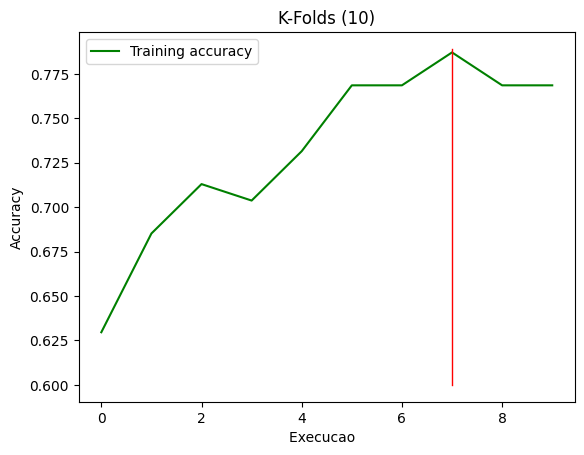

In [ ]:
z = range(0,len(acuracia))
plt.plot(z , acuracia, 'g', label='Training accuracy')
a = [7, 7]
b = [0.60, 0.789 ] 
plt.plot(a, b, color='r', linewidth=1) 

plt.title('K-Folds (10)')
plt.xlabel('Execucao  ')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 3)	Faça análises e novas implementações que você julgue importante para o seu trabalho. Não esqueça de explicar a motivação da análise realizada. 

#### Rascunho

In [ ]:
X = new_df_normalized.values[:,:-1].astype('float')
target = new_df_normalized.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)


train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

model = NeuralNetwork(n_input = n_input, n_output=n_output,hidden_neurons=35, output_activation='sigmoid')

accuracy = []
precision = []
f1score = []
recall = []

history, y_hat = train(model, train_loader, val_dataset, epochs=750, lr=0.01, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data,binary=binary)

accuracy =accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='weighted')
f1score = f1_score(y_test, y_pred,average='weighted')
recall = recall_score(y_test, y_pred,average='weighted')

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.692 | Val Loss: 0.6922 | Train Acc: 51.0000| Val Acc: 53.0000
Epoch 002: | Train Loss: 0.691 | Val Loss: 0.6920 | Train Acc: 51.0000| Val Acc: 51.0000
Epoch 003: | Train Loss: 0.691 | Val Loss: 0.6919 | Train Acc: 52.1818| Val Acc: 50.0000
Epoch 004: | Train Loss: 0.691 | Val Loss: 0.6918 | Train Acc: 52.3636| Val Acc: 51.0000
Epoch 005: | Train Loss: 0.690 | Val Loss: 0.6916 | Train Acc: 51.8182| Val Acc: 48.0000
Epoch 006: | Train Loss: 0.690 | Val Loss: 0.6915 | Train Acc: 51.5455| Val Acc: 48.0000
Epoch 007: | Train Loss: 0.690 | Val Loss: 0.6914 | Train Acc: 51.6364| Val Acc: 48.0000
Epoch 008: | Train Loss: 0.690 | Val Loss: 0.6913 | Train Acc: 51.3636| Val Acc: 48.0000
Epoch 009: | Train Loss: 0.689 | Val Loss: 0.6912 | Train Acc: 52.1818| Val Acc: 48.0000
Epoch 010: | Train Loss: 0.689 | Val Loss: 0.6910 | Train Acc: 52.4545| Val Acc: 48.0000
Epoch 011: | Train Loss: 0.689 | Val Loss: 0.6909 | Train Acc: 52.0909| Val Acc: 49.0000
Epoch 012: | Train Lo

#### Resposta

Uma combinação dos melhores resultados, nem sempre gera o melhor resultado.

lr = 0.065;

epoch = 600;

hidhidden_neurons = 70;

Aumentar a época ou a taxa de aprendizado não melhora a rede. Mas nesse caso de teste o aumento de neurônos na camada escondida melhorou a pefromance da rede.

In [ ]:
print(accuracy)

0.75


In [ ]:
print(precision)

0.7502572898799313


In [ ]:
print(f1score)

0.75006435006435


In [ ]:
print(recall)

0.75


              precision    recall  f1-score   support

           0       0.76      0.75      0.76        56
           1       0.74      0.75      0.74        52

    accuracy                           0.75       108
   macro avg       0.75      0.75      0.75       108
weighted avg       0.75      0.75      0.75       108



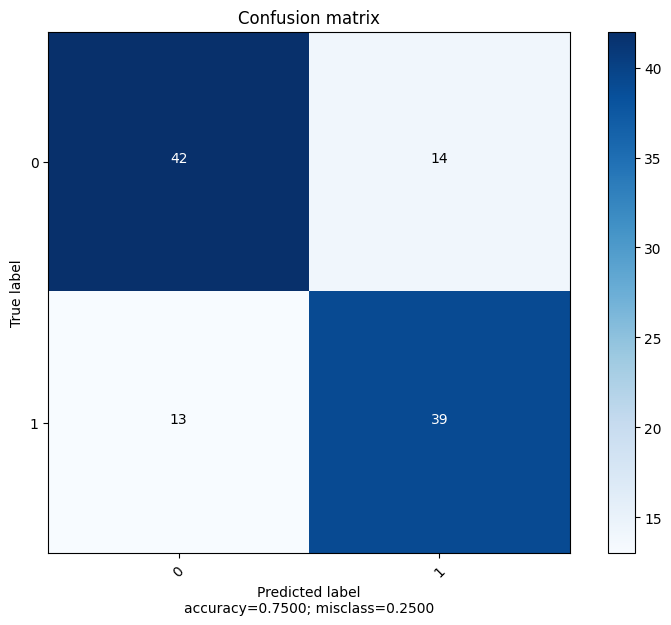

In [ ]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

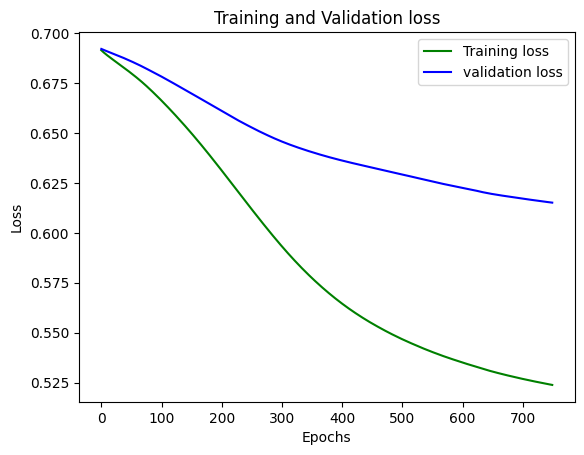

In [ ]:
loss_train = history['loss_train']
loss_val = history['loss_val']
ep = range(0,len(loss_train))
plt.plot(ep, loss_train, 'g', label='Training loss')
plt.plot(ep, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()